# Imports

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [29]:
# Load Good Data
df = pd.read_csv('../../02_analysis/df_good.csv')

# Load Target Data
df_target = pd.read_csv('../../02_analysis/df_target.csv')
df_target.drop(columns=['sr_gap_heuristic'], inplace=True)

# Load Predictors Data
df_predictors = pd.read_csv('../../02_analysis/mlm_results.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_77040/382248176.py:2: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../02_analysis/df_good.csv')


# Data Prep

## Clean and Organize Data

In [30]:
# Convert 'trial_date' to datetime and sort the dataframe
df['trial_date'] = pd.to_datetime(df['trial_date'])
# Sort
df = df.sort_values(by=['PID', 'trial_date'])

In [31]:
# Create new column task_nback_mode_hard
df['task_nback_mode_hard'] = df['task_nback_mode'].map({'hard': 1, 'easy': 0})

# Remove the original task_nback_mode column
df.drop(columns=['task_nback_mode'], inplace=True, errors='ignore')

In [32]:
df['task_nback_mode_hard']

0       1.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
8920    1.0
8921    1.0
8922    1.0
8923    1.0
8924    NaN
Name: task_nback_mode_hard, Length: 8925, dtype: float64

In [33]:
# create weekend column (1/0)
df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Create dummy variables for day_of_week (1/0)
df = pd.get_dummies(df, columns=['day_of_week'], prefix='day_of_week', dtype=int)

# remove day_of_week
df.drop(columns=['day_of_week'], inplace=True, errors='ignore')

In [34]:
# Remove app/web columns for device usage as these are then totaled
web_cols = [col for col in df.columns if 'passive_sk_device_web_usage' in col]
app_cols = [col for col in df.columns if 'passive_sk_device_app_usage' in col]

df.drop(columns=web_cols, inplace=True)
df.drop(columns=app_cols, inplace=True)

# remove existing residual columns since we will be calculating differences/residuals for all columns
cols = [col for col in df.columns if 'residual' in col]
df.drop(columns=cols, inplace=True)

# z scored some rts, can remove those
cols = [col for col in df.columns if 'rt_z' in col]
df.drop(columns=cols, inplace=True)

# Using the average RT
df.drop(['task_rt_1', 'task_rt_2', 'task_rt_3', 'task_rt_4'], axis=1, inplace=True)

# remove keyboard sentiment for emoji and word individually since they are combined
cols = [col for col in df.columns if 'keyboard_sentiment_emoji' in col]
df.drop(columns=cols, inplace=True)

# remove keyboard sentiment for emoji and word individually since they are combined
cols = [col for col in df.columns if 'keyboard_sentiment_word' in col]
df.drop(columns=cols, inplace=True)

# remove device sentiment as this is an error
cols = [col for col in df.columns if 'device_sentiment' in col]
df.drop(columns=cols, inplace=True)

# Remove simple gap which is just sr_DAILY_past24_gap
df.drop(columns='sr_gap_simple', inplace=True)

In [35]:
# Create new binary column 'tasks_complete' based on task_nback_time
df['tasks_complete'] = df['task_nback_time'].notna().astype(int)
df['survey_complete'] = df['sr_DAILY_goal1_set'].notna().astype(int)

In [36]:
df['survey_complete'].value_counts()

survey_complete
1    7829
0    1096
Name: count, dtype: int64

In [37]:
# Convert all task times to datetime and calculate minutes since midnight
task_time_cols = ['task_spatialSpan_tod', 'task_motivation_time', 'task_gng_time', 'task_nback_time']
for col in task_time_cols:
    df[col] = pd.to_datetime(df[col])
    df[col] = df[col].dt.hour * 60 + df[col].dt.minute + df[col].dt.second / 60

# Calculate task_start_time and task_end_time
df['task_start_time'] = df[task_time_cols].min(axis=1)
df['task_end_time'] = df[task_time_cols].max(axis=1)

# Calculate task_duration and clamp to 120 minutes
df['task_duration'] = (df['task_end_time'] - df['task_start_time']).clip(upper=120)

# Remove original time columns
df = df.drop(columns=task_time_cols)

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_77040/1607847272.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_77040/1607847272.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_77040/1607847272.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_77040/1607847272.py:4: UserWarning:

<Axes: >

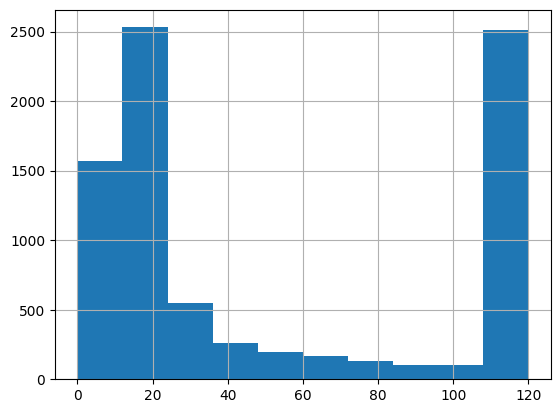

In [38]:
df['task_duration'].hist()

In [39]:
# create food df
df_food_cols = [col for col in df.columns if 'task_food' in col and col not in ['task_food_hunger_level', 'task_food_rt_flag']]
df_food = df[df_food_cols + ['PID', 'trial_date']]

# Function to calculate average for a given category and value type
def calc_avg_for_category(row, category, value_type):
    category_cols = [col for col in row.index if '_category' in col and row[col] == category]
    value_cols = [col.replace('_category', f'_{value_type}') for col in category_cols]
    values = [row[col] for col in value_cols if col in row.index]
    return sum(values) / len(values) if values else None

# Calculate average RT and rating for 'ht' and 'ut' categories
df['task_food_ht_avgRT'] = df_food.apply(lambda row: calc_avg_for_category(row, 'ht', 'rt'), axis=1)
df['task_food_ut_avgRT'] = df_food.apply(lambda row: calc_avg_for_category(row, 'ut', 'rt'), axis=1)
df['task_food_ht_avgRating'] = df_food.apply(lambda row: calc_avg_for_category(row, 'ht', 'rating'), axis=1)
df['task_food_ut_avgRating'] = df_food.apply(lambda row: calc_avg_for_category(row, 'ut', 'rating'), axis=1)

# Display the first few rows of the new columns
print(df[['PID', 'trial_date', 'task_food_ht_avgRT', 'task_food_ut_avgRT', 'task_food_ht_avgRating', 'task_food_ut_avgRating']].head())


                                    PID trial_date  task_food_ht_avgRT  \
0  0151d9f1-1644-4437-805e-02f5e244a690 2023-01-30              2393.6   
1  0151d9f1-1644-4437-805e-02f5e244a690 2023-01-31              3001.8   
2  0151d9f1-1644-4437-805e-02f5e244a690 2023-02-01              4237.8   
3  0151d9f1-1644-4437-805e-02f5e244a690 2023-02-02              1899.8   
4  0151d9f1-1644-4437-805e-02f5e244a690 2023-02-03              1927.6   

   task_food_ut_avgRT  task_food_ht_avgRating  task_food_ut_avgRating  
0              2545.4                    -0.6                    -3.4  
1              2637.2                    -0.8                    -0.2  
2              6343.0                    -0.8                    -0.8  
3              2427.6                    -2.0                    -1.2  
4              1864.8                    -1.0                    -0.2  


In [40]:
# drop food columns
df.drop(columns=df_food_cols, inplace=True)

# all columns with flag in title
flag_cols = [col for col in df.columns if '_flag' in col]
df.drop(columns=flag_cols, inplace=True)

# drop callumns with text entry or irrelevant
drop_cols = [
    'sr_DAILY_goal1_set',
    'sr_DAILY_goal2_set',
    'sr_DAILY_past24_gapCause',
    'sr_DAILY_past48to24_gapCause',
    'sr_DAILY_survey_missed',
    'sr_DAILY_survey_situation1_surveys',
    'sr_DAILY_survey_situation2_surveys',
    'sr_IDEAL_values_monthly1',
    'sr_IDEAL_values_monthly2',
    'sr_IDEAL_values_monthly3',
    'sr_MONTHLY_goal_set1',
    'sr_MONTHLY_goal_set2',
    'sr_WEEKLY_goal_set1',
    'sr_WEEKLY_goal_set2',
]

df.drop(columns=drop_cols, inplace=True)

In [41]:
# Add binary variable that notes watch-wearing
df['watch_wearing'] = df['passive_hk_hr_variability'].notna().astype(int)
df.watch_wearing.value_counts()

watch_wearing
1    6810
0    2115
Name: count, dtype: int64

In [42]:
# Update activeEnergyBurned to 0 where NaN and watch was worn
mask = (df['watch_wearing'] == 1) & (df['passive_hk_activity_activeEnergyBurned'].isna())
df.loc[mask, 'passive_hk_activity_activeEnergyBurned'] = 0

In [43]:
# Replace moves value in TOH with NaN if solved is 0
df.loc[df['task_hanoi_solved'] == 0, 'task_hanoi_moves'] = np.nan

## Fix Sensorkit Data

<div style="background-color: #ffebee; padding: 10px; border-radius: 5px; border-left: 5px solid #ef5350;">
<strong>Note:</strong><br>
Before detrending need to remove 0s that are not "real" 0s but rather represent missing data
</div>

This is specifically for sensorkit (`_sk_`) data. 

In preprocessing some variables had 0s imputed for missing data. This is a problem for detrending as it will bias the data.

See the example below:

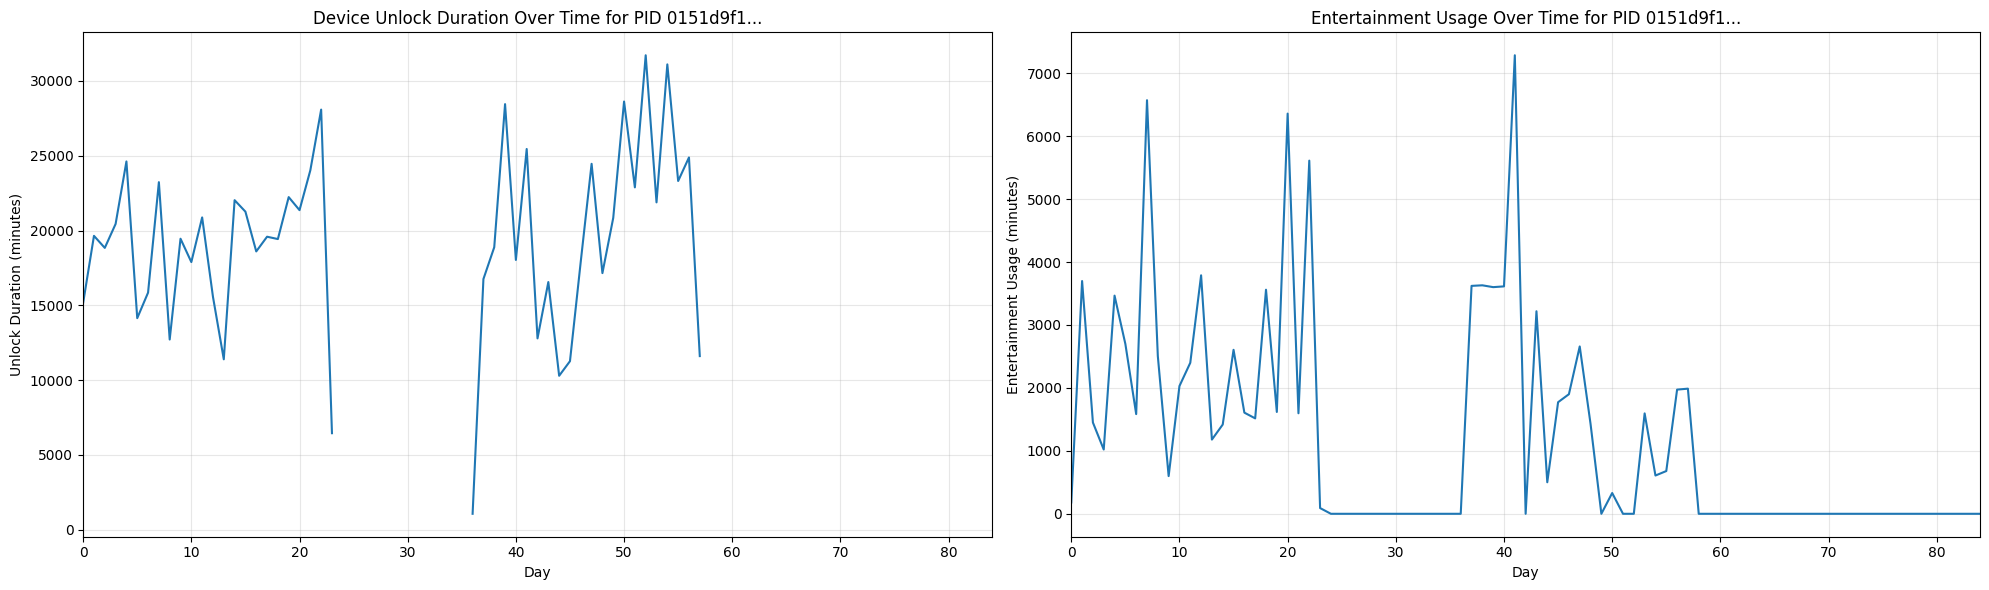

In [44]:
pid = '0151d9f1-1644-4437-805e-02f5e244a690'

# Get the data for this PID
data_unlock = df.loc[df['PID'] == pid, 'passive_sk_device_total_unlock_duration']
data_entertainment = df.loc[df['PID'] == pid, 'passive_sk_device_total_usage_entertainment']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

# First subplot - unlock duration
ax1.plot(data_unlock.index, data_unlock.values)
ax1.set_title(f'Device Unlock Duration Over Time for PID {pid[:8]}...')
ax1.set_xlabel('Day')
ax1.set_ylabel('Unlock Duration (minutes)')
ax1.set_xlim(0, 84)
ax1.grid(True, alpha=0.3)

# Second subplot - entertainment usage
ax2.plot(data_entertainment.index, data_entertainment.values)
ax2.set_title(f'Entertainment Usage Over Time for PID {pid[:8]}...')
ax2.set_xlabel('Day')
ax2.set_ylabel('Entertainment Usage (minutes)')
ax2.set_xlim(0, 84)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Our solution is to use `passive_sk_device_total_unlock_duration` which does not have imputed 0s as a guide for converting other variable values to NaN.

In [45]:
df_cleaned = df.copy()

# Get all columns containing '_sk_'
sk_cols = [col for col in df_cleaned.columns if '_sk_' in col]

# Remove unlock duration from list since we use it as reference
sk_cols.remove('passive_sk_device_total_unlock_duration')

# Group by PID and day
for pid in df_cleaned['PID'].unique():
    pid_data = df_cleaned[df_cleaned['PID'] == pid]
    
    # Get indices where unlock duration is NaN
    nan_indices = pid_data[pid_data['passive_sk_device_total_unlock_duration'].isna()].index
    
    # Set all other sk columns to NaN at those indices
    df_cleaned.loc[nan_indices, sk_cols] = np.nan

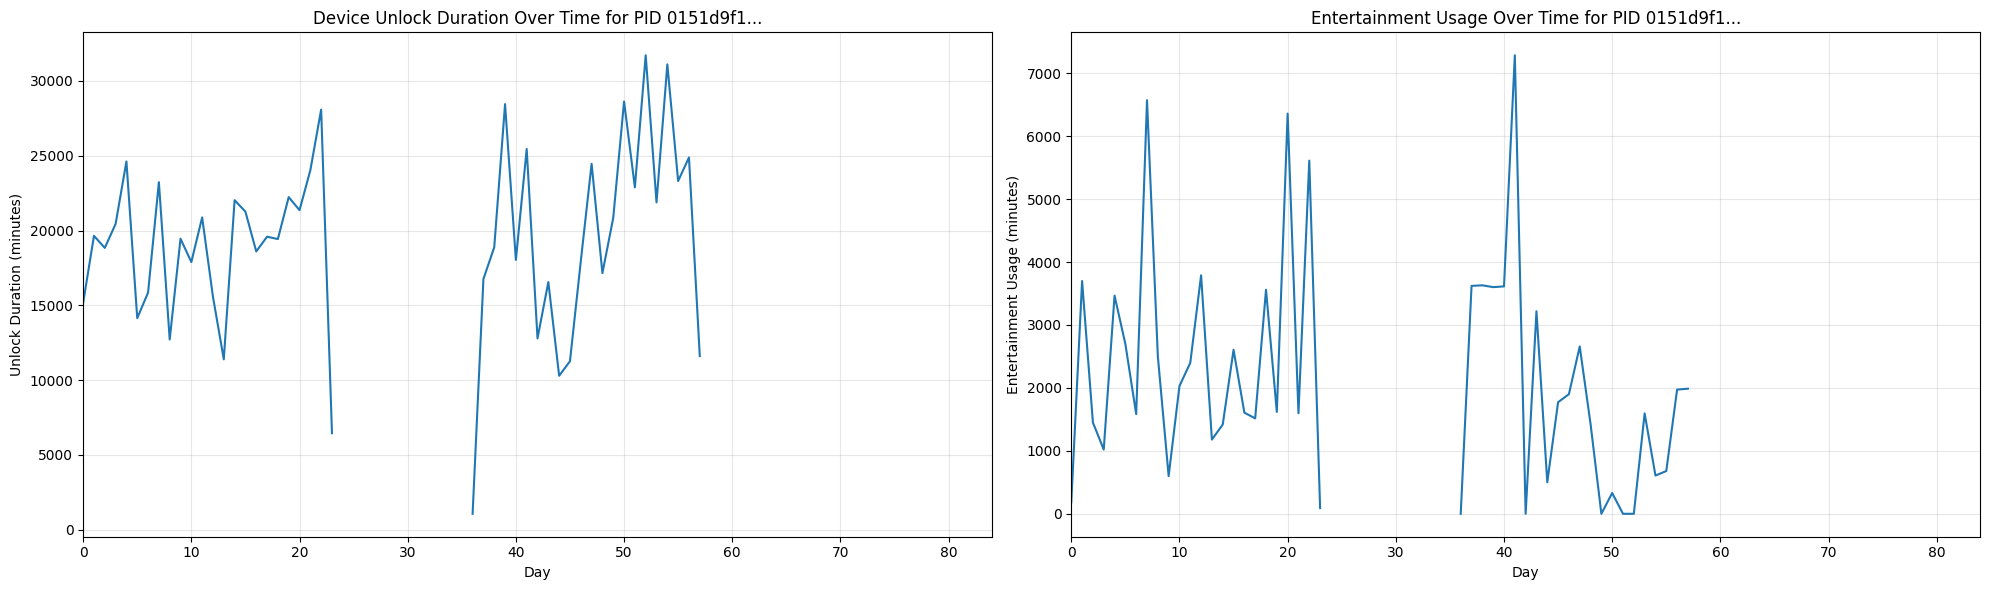

In [46]:
pid = '0151d9f1-1644-4437-805e-02f5e244a690'

# Get the data for this PID
data_unlock = df_cleaned.loc[df_cleaned['PID'] == pid, 'passive_sk_device_total_unlock_duration']
data_entertainment = df_cleaned.loc[df_cleaned['PID'] == pid, 'passive_sk_device_total_usage_entertainment']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

# First subplot - unlock duration
ax1.plot(data_unlock.index, data_unlock.values)
ax1.set_title(f'Device Unlock Duration Over Time for PID {pid[:8]}...')
ax1.set_xlabel('Day')
ax1.set_ylabel('Unlock Duration (minutes)')
ax1.set_xlim(0, 84)
ax1.grid(True, alpha=0.3)

# Second subplot - entertainment usage
ax2.plot(data_entertainment.index, data_entertainment.values)
ax2.set_title(f'Entertainment Usage Over Time for PID {pid[:8]}...')
ax2.set_xlabel('Day')
ax2.set_ylabel('Entertainment Usage (minutes)')
ax2.set_xlim(0, 84)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

It is notable, especially with unlock duration, that the days preceding and proceeding NaN values tend to be much lower than the rest of the days.

To correct for this we will remove days preceding and proceeding NaN values.

In [47]:
# Get all columns containing '_sk_'
sk_cols = [col for col in df_cleaned.columns if '_sk_' in col]

# For each PID
for pid in df_cleaned['PID'].unique():
    # Get data for this PID
    pid_data = df_cleaned[df_cleaned['PID'] == pid].copy()
    
    # Find indices where unlock duration is NaN
    nan_indices = pid_data['passive_sk_device_total_unlock_duration'].isna()
    nan_indices = pid_data[nan_indices].index
    
    if len(nan_indices) > 0:
        # Get indices before and after NaN values, but only if they're part of a sequence
        indices_to_remove = []
        for i in range(len(nan_indices)-1):
            # Check if this NaN and the next one are consecutive
            if nan_indices[i+1] - nan_indices[i] == 1:
                # If consecutive, add the day before the first and after the second
                if nan_indices[i]-1 in pid_data.index:
                    indices_to_remove.append(nan_indices[i]-1)
                if nan_indices[i+1]+1 in pid_data.index:
                    indices_to_remove.append(nan_indices[i+1]+1)
                    
        # Add the original NaN indices
        indices_to_remove.extend(nan_indices)
        indices_to_remove = list(set(indices_to_remove))
        
        # Set sk columns to NaN for these indices
        df_cleaned.loc[indices_to_remove, sk_cols] = np.nan

### Plot Original vs Cleaned

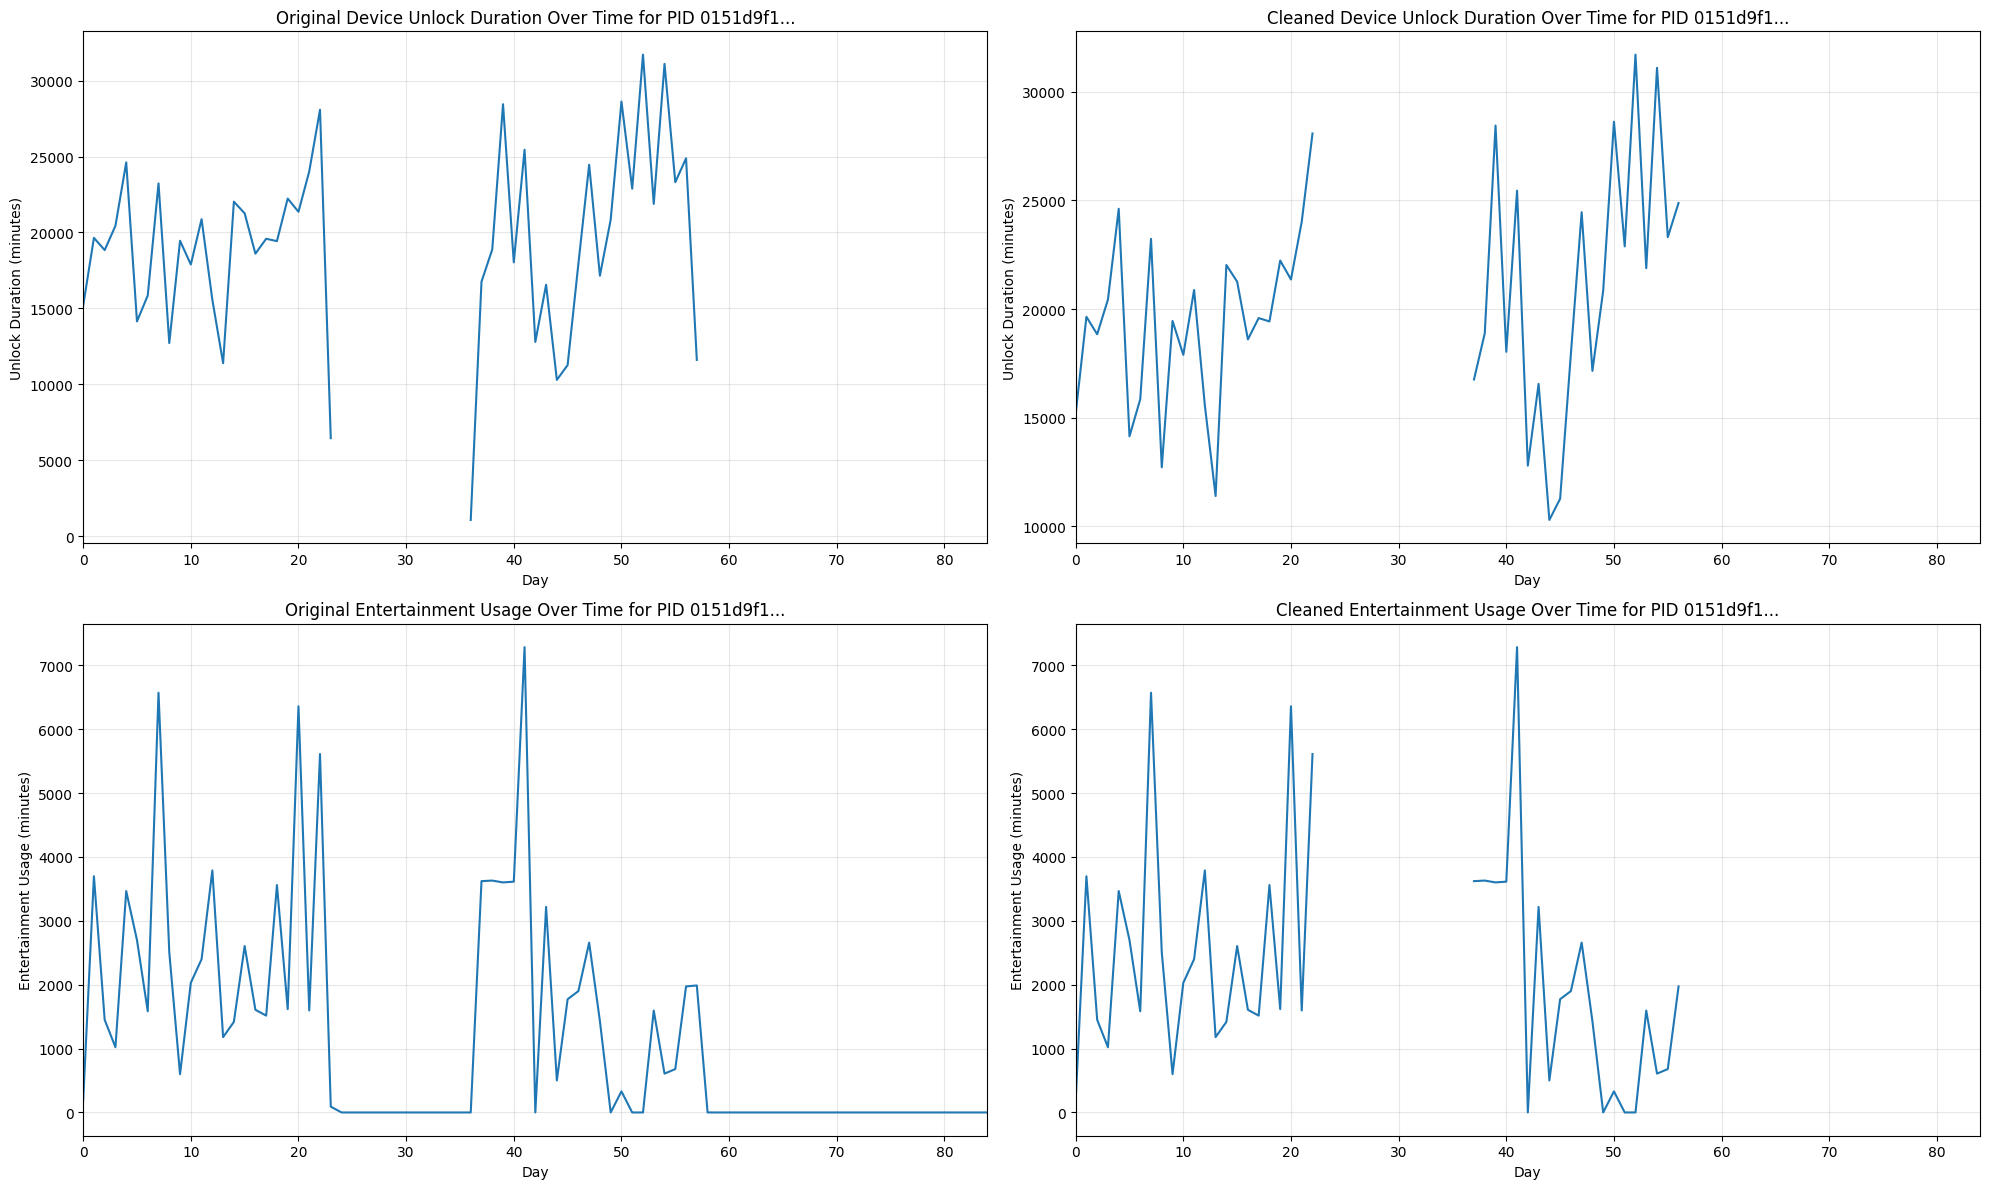

In [48]:
pid = '0151d9f1-1644-4437-805e-02f5e244a690'

# Get the data for this PID from both dataframes
data_unlock_original = df.loc[df['PID'] == pid, 'passive_sk_device_total_unlock_duration']
data_unlock_filtered = df_cleaned.loc[df_cleaned['PID'] == pid, 'passive_sk_device_total_unlock_duration']
data_ent_original = df.loc[df['PID'] == pid, 'passive_sk_device_total_usage_entertainment'] 
data_ent_filtered = df_cleaned.loc[df_cleaned['PID'] == pid, 'passive_sk_device_total_usage_entertainment']

# Create figure with four subplots in 2 rows
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,12))

# First subplot - original unlock duration
ax1.plot(data_unlock_original.index, data_unlock_original.values)
ax1.set_title(f'Original Device Unlock Duration Over Time for PID {pid[:8]}...')
ax1.set_xlabel('Day')
ax1.set_ylabel('Unlock Duration (minutes)')
ax1.set_xlim(0, 84)
ax1.grid(True, alpha=0.3)

# Second subplot - filtered unlock duration
ax2.plot(data_unlock_filtered.index, data_unlock_filtered.values)
ax2.set_title(f'Cleaned Device Unlock Duration Over Time for PID {pid[:8]}...')
ax2.set_xlabel('Day')
ax2.set_ylabel('Unlock Duration (minutes)')
ax2.set_xlim(0, 84)
ax2.grid(True, alpha=0.3)

# Third subplot - original entertainment usage
ax3.plot(data_ent_original.index, data_ent_original.values)
ax3.set_title(f'Original Entertainment Usage Over Time for PID {pid[:8]}...')
ax3.set_xlabel('Day')
ax3.set_ylabel('Entertainment Usage (minutes)')
ax3.set_xlim(0, 84)
ax3.grid(True, alpha=0.3)

# Fourth subplot - filtered entertainment usage
ax4.plot(data_ent_filtered.index, data_ent_filtered.values)
ax4.set_title(f'Cleaned Entertainment Usage Over Time for PID {pid[:8]}...')
ax4.set_xlabel('Day')
ax4.set_ylabel('Entertainment Usage (minutes)')
ax4.set_xlim(0, 84)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Remove Outliers

First just curious what are the max values for each passive device measure.

In [49]:
# Get all columns that start with passive_sk_device_total_usage_
usage_cols = [col for col in df_cleaned.columns if col.startswith('passive_sk_device_total_usage_')]

# Calculate max values in hours for each column
print("Maximum usage times in hours:")
for col in usage_cols:
    max_hours = df_cleaned[col].max() / 3600
    print(f"{col}: {max_hours:.2f}")


Maximum usage times in hours:
passive_sk_device_total_usage_books: 9.90
passive_sk_device_total_usage_business: 6.60
passive_sk_device_total_usage_catalogs: 0.00
passive_sk_device_total_usage_developer_tools: 0.01
passive_sk_device_total_usage_education: 10.16
passive_sk_device_total_usage_entertainment: 11.97
passive_sk_device_total_usage_finance: 1.82
passive_sk_device_total_usage_food_and_drink: 2.68
passive_sk_device_total_usage_games: 6.53
passive_sk_device_total_usage_graphics_and_design: 0.65
passive_sk_device_total_usage_health_and_fitness: 6.71
passive_sk_device_total_usage_kids: 0.00
passive_sk_device_total_usage_lifestyle: 4.97
passive_sk_device_total_usage_medical: 0.57
passive_sk_device_total_usage_miscellaneous: 9.04
passive_sk_device_total_usage_music: 5.15
passive_sk_device_total_usage_navigation: 3.83
passive_sk_device_total_usage_news: 9.54
passive_sk_device_total_usage_newsstand: 0.00
passive_sk_device_total_usage_photo_and_video: 14.90
passive_sk_device_total_usage_

Subject 1b9b62f1-095b-4819-92a0-ea8e7abee884 has max weather usage of 6.25 hours


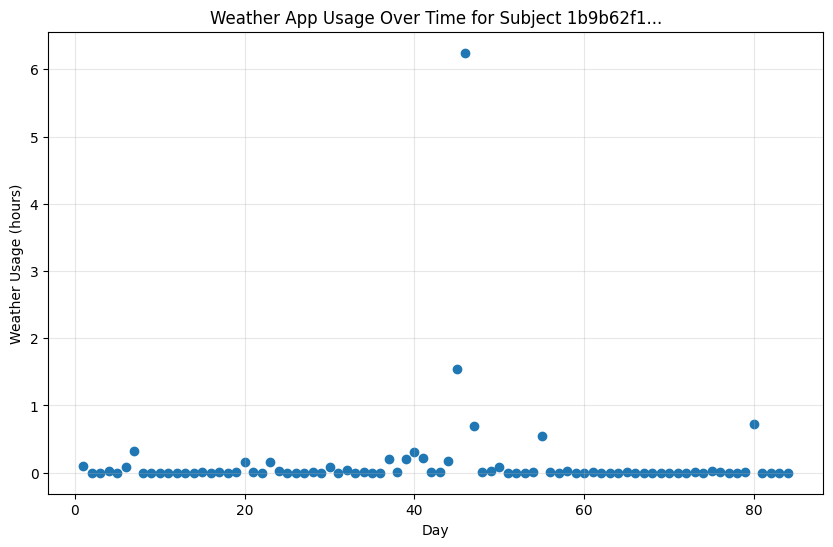

In [50]:
# Find the row with max weather usage and plot their usage over time
max_weather_idx = df_cleaned['passive_sk_device_total_usage_weather'].idxmax()
max_weather_pid = df_cleaned.loc[max_weather_idx, 'PID']
max_weather_value = df_cleaned.loc[max_weather_idx, 'passive_sk_device_total_usage_weather']

print(f"Subject {max_weather_pid} has max weather usage of {max_weather_value/3600:.2f} hours")

# Plot weather usage over time for this subject
subject_data = df_cleaned[df_cleaned['PID'] == max_weather_pid]
plt.figure(figsize=(10, 6))
plt.scatter(subject_data['day'], subject_data['passive_sk_device_total_usage_weather']/3600)
plt.title(f'Weather App Usage Over Time for Subject {max_weather_pid[:8]}...')
plt.xlabel('Day')
plt.ylabel('Weather Usage (hours)')
plt.grid(True, alpha=0.3)
plt.show()

### Outlier Identification Comparision

<div class="alert alert-info">
    <b>💡DBSCAN <code>min_samples</code> parameter</b><br>
    <hr>
    <b>For low-dimensional data</b>: Set <code>min_samples</code> to at least the number of dimensions plus one (<code>min_samples >= D + 1</code>), where <code>D</code> is the number of features.
</div>

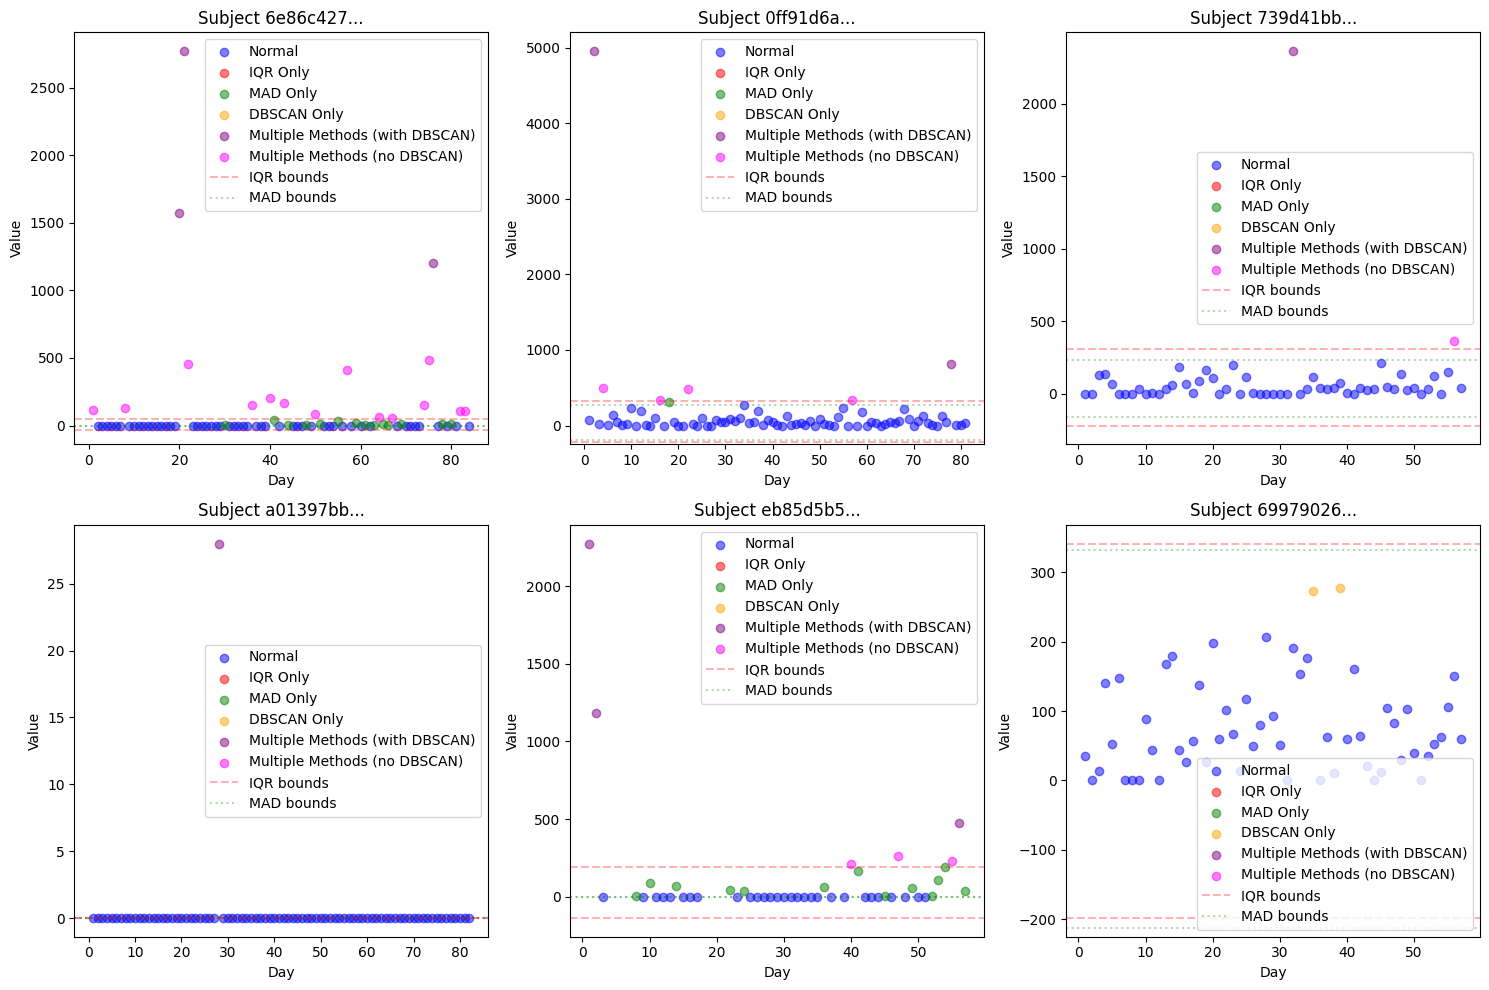


Outlier analysis for passive_sk_device_total_usage_business:

Subject-level statistics:
Number of subjects with IQR outliers: 96
Percentage of subjects with IQR outliers: 91.4%
Number of subjects with MAD outliers: 99
Percentage of subjects with MAD outliers: 94.3%
Number of subjects with DBSCAN outliers: 99
Percentage of subjects with DBSCAN outliers: 94.3%

Datapoint-level statistics:
Total number of datapoints: 6541
Total IQR outliers: 742
Percentage of IQR outliers: 11.3%
Total MAD outliers: 1290
Percentage of MAD outliers: 19.7%
Total DBSCAN outliers: 245
Percentage of DBSCAN outliers: 3.7%


In [51]:
# Plot outliers for 6 random subjects using IQR, MAD and DBSCAN methods
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import median_abs_deviation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

col = 'passive_sk_device_total_usage_business'

# Randomly select 6 subjects
random_subjects = random.sample(list(df_cleaned['PID'].unique()), 6)

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot data for each subject
for idx, pid in enumerate(random_subjects):
    mask = df_cleaned['PID'] == pid
    subject_data = df_cleaned.loc[mask, [col, 'day']]
    
    # Drop NaN values
    subject_data = subject_data.dropna()
    
    # Calculate IQR bounds
    Q1 = subject_data[col].quantile(0.25)
    Q3 = subject_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 2.466 * IQR
    upper_bound_iqr = Q3 + 2.466 * IQR
    
    # Calculate MAD bounds
    median = subject_data[col].median()
    mad = median_abs_deviation(subject_data[col], scale='normal', nan_policy='omit')
    lower_bound_mad = median - 4 * mad
    upper_bound_mad = median + 4 * mad
    
    # DBSCAN outlier detection (only on values, not days)
    if len(subject_data) > 3:  # Only run DBSCAN if enough points
        X = subject_data[[col]].values
        X = StandardScaler().fit_transform(X)
        dbscan = DBSCAN(eps=0.5, min_samples=3)
        clusters = dbscan.fit_predict(X)
        outlier_mask_dbscan = clusters == -1
    else:
        outlier_mask_dbscan = np.zeros(len(subject_data), dtype=bool)
    
    # Identify outliers using all methods
    outlier_mask_iqr = (subject_data[col] < lower_bound_iqr) | (subject_data[col] > upper_bound_iqr)
    outlier_mask_mad = (subject_data[col] < lower_bound_mad) | (subject_data[col] > upper_bound_mad)
    
    # Plot normal points
    normal_mask = ~(outlier_mask_iqr | outlier_mask_mad | outlier_mask_dbscan)
    axes[idx].scatter(subject_data.loc[normal_mask, 'day'], 
                     subject_data.loc[normal_mask, col],
                     c='blue', alpha=0.5, label='Normal')
    
    # Plot IQR-only outliers
    iqr_only = outlier_mask_iqr & ~outlier_mask_mad & ~outlier_mask_dbscan
    axes[idx].scatter(subject_data.loc[iqr_only, 'day'],
                     subject_data.loc[iqr_only, col],
                     c='red', alpha=0.5, label='IQR Only')
    
    # Plot MAD-only outliers  
    mad_only = outlier_mask_mad & ~outlier_mask_iqr & ~outlier_mask_dbscan
    axes[idx].scatter(subject_data.loc[mad_only, 'day'],
                     subject_data.loc[mad_only, col],
                     c='green', alpha=0.5, label='MAD Only')
    
    # Plot DBSCAN-only outliers
    dbscan_only = outlier_mask_dbscan & ~outlier_mask_iqr & ~outlier_mask_mad
    axes[idx].scatter(subject_data.loc[dbscan_only, 'day'],
                     subject_data.loc[dbscan_only, col],
                     c='orange', alpha=0.5, label='DBSCAN Only')
    
    # Plot points that are outliers in multiple methods including DBSCAN
    multiple_with_dbscan = outlier_mask_dbscan & (outlier_mask_iqr | outlier_mask_mad)
    axes[idx].scatter(subject_data.loc[multiple_with_dbscan, 'day'],
                     subject_data.loc[multiple_with_dbscan, col],
                     c='purple', alpha=0.5, label='Multiple Methods (with DBSCAN)')
    
    # Plot points that are outliers in multiple methods not including DBSCAN
    multiple_without_dbscan = outlier_mask_iqr & outlier_mask_mad & ~outlier_mask_dbscan
    axes[idx].scatter(subject_data.loc[multiple_without_dbscan, 'day'],
                     subject_data.loc[multiple_without_dbscan, col],
                     c='magenta', alpha=0.5, label='Multiple Methods (no DBSCAN)')
    
    # Add horizontal lines for bounds
    axes[idx].axhline(y=lower_bound_iqr, color='r', linestyle='--', alpha=0.3, label='IQR bounds')
    axes[idx].axhline(y=upper_bound_iqr, color='r', linestyle='--', alpha=0.3)
    axes[idx].axhline(y=lower_bound_mad, color='g', linestyle=':', alpha=0.3, label='MAD bounds') 
    axes[idx].axhline(y=upper_bound_mad, color='g', linestyle=':', alpha=0.3)
    
    axes[idx].set_title(f'Subject {pid[:8]}...')
    axes[idx].set_ylabel('Value')
    axes[idx].set_xlabel('Day')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nOutlier analysis for {col}:")

# Initialize counters for total outliers
total_outliers_iqr = 0
total_outliers_mad = 0 
total_outliers_dbscan = 0
total_datapoints = 0

# Count subjects with outliers and total outliers using IQR method
subjects_with_outliers_iqr = 0
for pid in df_cleaned['PID'].unique():
    subject_data = df_cleaned.loc[df_cleaned['PID'] == pid, col].dropna()
    if len(subject_data) > 0:
        total_datapoints += len(subject_data)
        Q1 = subject_data.quantile(0.25)
        Q3 = subject_data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = (subject_data < (Q1 - 2.466 * IQR)) | (subject_data > (Q3 + 2.466 * IQR))
        if any(outliers):
            subjects_with_outliers_iqr += 1
        total_outliers_iqr += sum(outliers)

# Count subjects with outliers and total outliers using MAD method
subjects_with_outliers_mad = 0
for pid in df_cleaned['PID'].unique():
    subject_data = df_cleaned.loc[df_cleaned['PID'] == pid, col].dropna()
    if len(subject_data) > 0:
        median = subject_data.median()
        mad = median_abs_deviation(subject_data, scale='normal', nan_policy='omit')
        outliers = (subject_data < (median - 4 * mad)) | (subject_data > (median + 4 * mad))
        if any(outliers):
            subjects_with_outliers_mad += 1
        total_outliers_mad += sum(outliers)

# Count subjects with outliers and total outliers using DBSCAN method
subjects_with_outliers_dbscan = 0
for pid in df_cleaned['PID'].unique():
    subject_data = df_cleaned.loc[df_cleaned['PID'] == pid, [col]].dropna()
    if len(subject_data) > 3:  # Only run DBSCAN if enough points
        X = StandardScaler().fit_transform(subject_data)
        clusters = DBSCAN(eps=0.5, min_samples=3).fit_predict(X)
        outliers = clusters == -1
        if any(outliers):  # -1 indicates outliers in DBSCAN
            subjects_with_outliers_dbscan += 1
        total_outliers_dbscan += sum(outliers)

total_subjects = len(df_cleaned['PID'].unique())

print("\nSubject-level statistics:")
print(f"Number of subjects with IQR outliers: {subjects_with_outliers_iqr}")
print(f"Percentage of subjects with IQR outliers: {(subjects_with_outliers_iqr / total_subjects) * 100:.1f}%")
print(f"Number of subjects with MAD outliers: {subjects_with_outliers_mad}")
print(f"Percentage of subjects with MAD outliers: {(subjects_with_outliers_mad / total_subjects) * 100:.1f}%")
print(f"Number of subjects with DBSCAN outliers: {subjects_with_outliers_dbscan}")
print(f"Percentage of subjects with DBSCAN outliers: {(subjects_with_outliers_dbscan / total_subjects) * 100:.1f}%")

print("\nDatapoint-level statistics:")
print(f"Total number of datapoints: {total_datapoints}")
print(f"Total IQR outliers: {total_outliers_iqr}")
print(f"Percentage of IQR outliers: {(total_outliers_iqr / total_datapoints) * 100:.1f}%")
print(f"Total MAD outliers: {total_outliers_mad}")
print(f"Percentage of MAD outliers: {(total_outliers_mad / total_datapoints) * 100:.1f}%")
print(f"Total DBSCAN outliers: {total_outliers_dbscan}")
print(f"Percentage of DBSCAN outliers: {(total_outliers_dbscan / total_datapoints) * 100:.1f}%")


<div class="alert alert-info">
As we can see from the <code>passive_sk_device_total_usage_business</code> variable, there are passive measures that are heavily zero-inflated...
</div>

In [52]:
# Calculate number of zeros per PID for business usage
zeros_by_pid = df_cleaned.groupby('PID').apply(lambda x: (x['passive_sk_device_total_usage_business'] == 0).sum())

# Calculate mean and std of number of zeros across PIDs
mean_zeros = zeros_by_pid.mean()
std_zeros = zeros_by_pid.std()

print(f"Average number of zeros per participant for business usage: {mean_zeros:.2f} (SD = {std_zeros:.2f})")

Average number of zeros per participant for business usage: 40.37 (SD = 20.60)


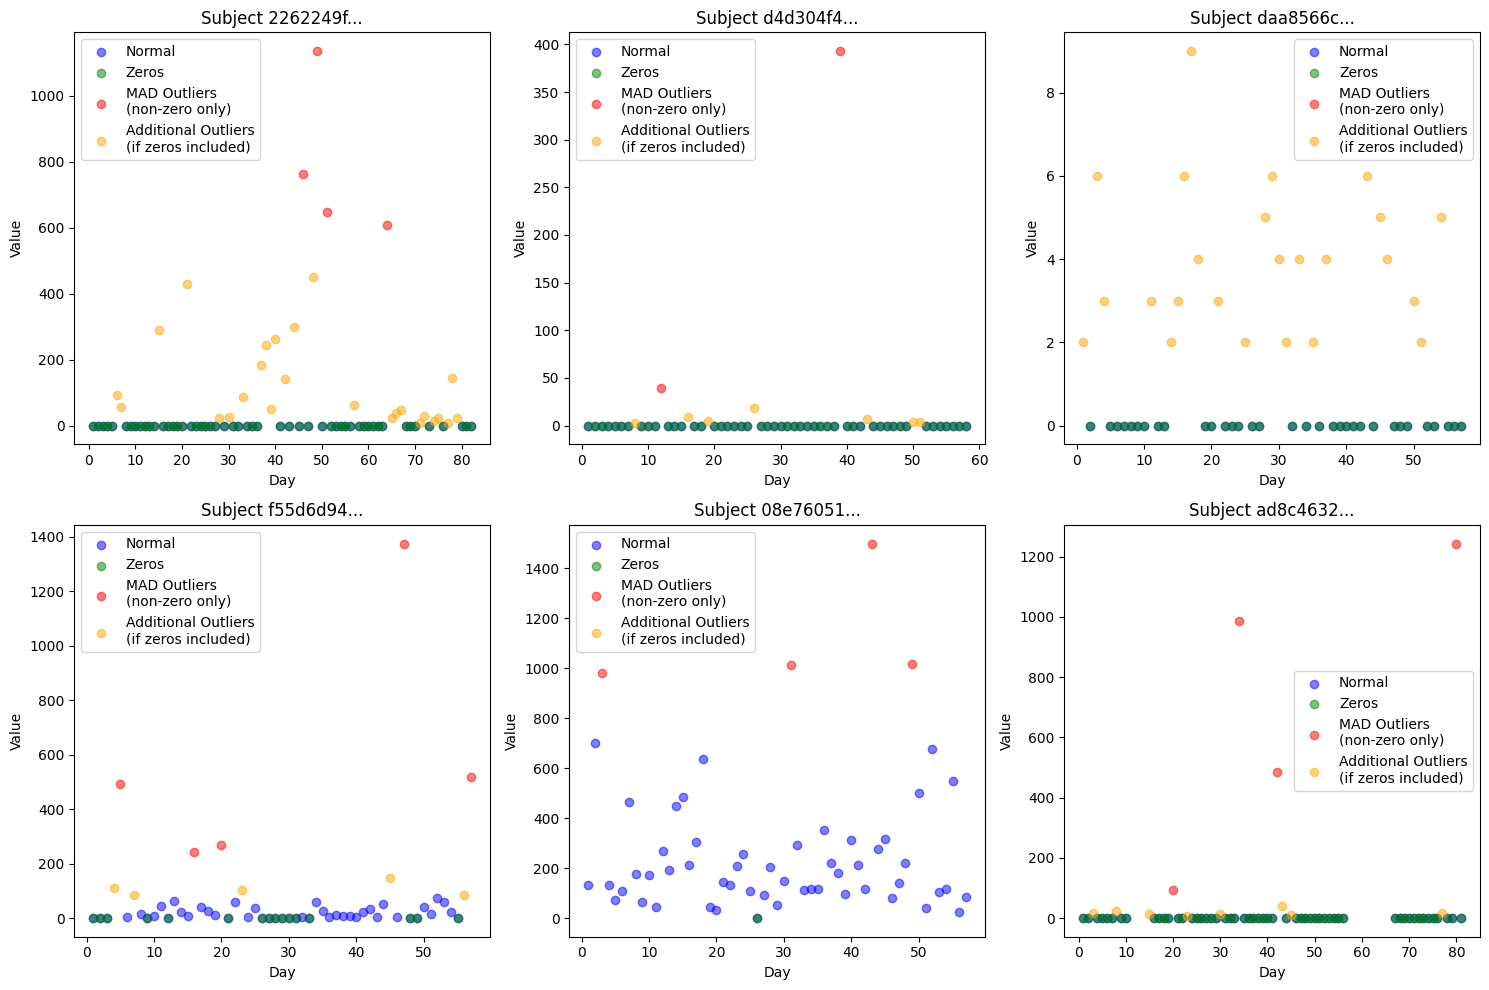


Outlier analysis for passive_sk_device_total_usage_business:

Subject-level statistics:
Number of subjects with MAD outliers (non-zero method): 86
Percentage of subjects with MAD outliers (non-zero method): 81.9%
Number of subjects with outliers if zeros included: 99
Percentage of subjects with outliers if zeros included: 94.3%

Datapoint-level statistics:
Total number of datapoints: 6541
Total MAD outliers (non-zero method): 274
Percentage of MAD outliers (non-zero method): 4.2%
Total outliers if zeros included: 1290
Percentage of outliers if zeros included: 19.7%


In [53]:
# Plot outliers for 6 random subjects using MAD method with and without zeros in calculation
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import median_abs_deviation

col = 'passive_sk_device_total_usage_business'

# Randomly select 6 subjects
random_subjects = random.sample(list(df_cleaned['PID'].unique()), 6)

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot data for each subject
for idx, pid in enumerate(random_subjects):
    mask = df_cleaned['PID'] == pid
    subject_data = df_cleaned.loc[mask, [col, 'day']]
    
    # Drop NaN values
    subject_data = subject_data.dropna()
    
    # MAD outlier detection on non-zero values only
    non_zero_data = subject_data[subject_data[col] > 0][col]
    if len(non_zero_data) > 0:
        median = non_zero_data.median()
        mad = median_abs_deviation(non_zero_data, scale='normal', nan_policy='omit')
        outlier_mask_mad = (subject_data[col] > (median + 4 * mad)) & (subject_data[col] > 0)
        
        # Calculate what outliers would have been if zeros were included
        all_data_median = subject_data[col].median()
        all_data_mad = median_abs_deviation(subject_data[col], scale='normal', nan_policy='omit')
        outlier_mask_with_zeros = subject_data[col] > (all_data_median + 4 * all_data_mad)
    else:
        outlier_mask_mad = np.zeros(len(subject_data), dtype=bool)
        outlier_mask_with_zeros = np.zeros(len(subject_data), dtype=bool)
    
    # Plot normal points (non-outliers)
    normal_mask = ~outlier_mask_mad & ~outlier_mask_with_zeros
    axes[idx].scatter(subject_data.loc[normal_mask, 'day'], 
                     subject_data.loc[normal_mask, col],
                     c='blue', alpha=0.5, label='Normal')
    
    # Plot zeros separately
    zero_mask = subject_data[col] == 0
    axes[idx].scatter(subject_data.loc[zero_mask, 'day'],
                     subject_data.loc[zero_mask, col],
                     c='green', alpha=0.5, label='Zeros')
    
    # Plot MAD outliers (non-zero method)
    axes[idx].scatter(subject_data.loc[outlier_mask_mad, 'day'],
                     subject_data.loc[outlier_mask_mad, col],
                     c='red', alpha=0.5, label='MAD Outliers\n(non-zero only)')
    
    # Plot points that would have been outliers if zeros were included
    additional_outliers = outlier_mask_with_zeros & ~outlier_mask_mad
    axes[idx].scatter(subject_data.loc[additional_outliers, 'day'],
                     subject_data.loc[additional_outliers, col],
                     c='orange', alpha=0.5, label='Additional Outliers\n(if zeros included)')
    
    axes[idx].set_title(f'Subject {pid[:8]}...')
    axes[idx].set_ylabel('Value')
    axes[idx].set_xlabel('Day')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nOutlier analysis for {col}:")

# Initialize counters
total_outliers_mad = 0
total_outliers_with_zeros = 0
total_datapoints = 0
subjects_with_outliers_mad = 0
subjects_with_outliers_with_zeros = 0

for pid in df_cleaned['PID'].unique():
    subject_data = df_cleaned.loc[df_cleaned['PID'] == pid, [col]].dropna()
    total_datapoints += len(subject_data)
    
    # MAD outliers on non-zero values
    non_zero_data = subject_data[subject_data[col] > 0][col]
    if len(non_zero_data) > 0:
        median = non_zero_data.median()
        mad = median_abs_deviation(non_zero_data, scale='normal', nan_policy='omit')
        outliers_mad = (subject_data[col] > (median + 4 * mad)) & (subject_data[col] > 0)
        
        # Calculate what outliers would have been if zeros were included
        all_data_median = subject_data[col].median()
        all_data_mad = median_abs_deviation(subject_data[col], scale='normal', nan_policy='omit')
        outliers_with_zeros = subject_data[col] > (all_data_median + 4 * all_data_mad)
        
        if any(outliers_mad):
            subjects_with_outliers_mad += 1
        if any(outliers_with_zeros):
            subjects_with_outliers_with_zeros += 1
            
        total_outliers_mad += sum(outliers_mad)
        total_outliers_with_zeros += sum(outliers_with_zeros)

total_subjects = len(df_cleaned['PID'].unique())

print("\nSubject-level statistics:")
print(f"Number of subjects with MAD outliers (non-zero method): {subjects_with_outliers_mad}")
print(f"Percentage of subjects with MAD outliers (non-zero method): {(subjects_with_outliers_mad / total_subjects) * 100:.1f}%")
print(f"Number of subjects with outliers if zeros included: {subjects_with_outliers_with_zeros}")
print(f"Percentage of subjects with outliers if zeros included: {(subjects_with_outliers_with_zeros / total_subjects) * 100:.1f}%")

print("\nDatapoint-level statistics:")
print(f"Total number of datapoints: {total_datapoints}")
print(f"Total MAD outliers (non-zero method): {total_outliers_mad}")
print(f"Percentage of MAD outliers (non-zero method): {(total_outliers_mad / total_datapoints) * 100:.1f}%")
print(f"Total outliers if zeros included: {total_outliers_with_zeros}")
print(f"Percentage of outliers if zeros included: {(total_outliers_with_zeros / total_datapoints) * 100:.1f}%")


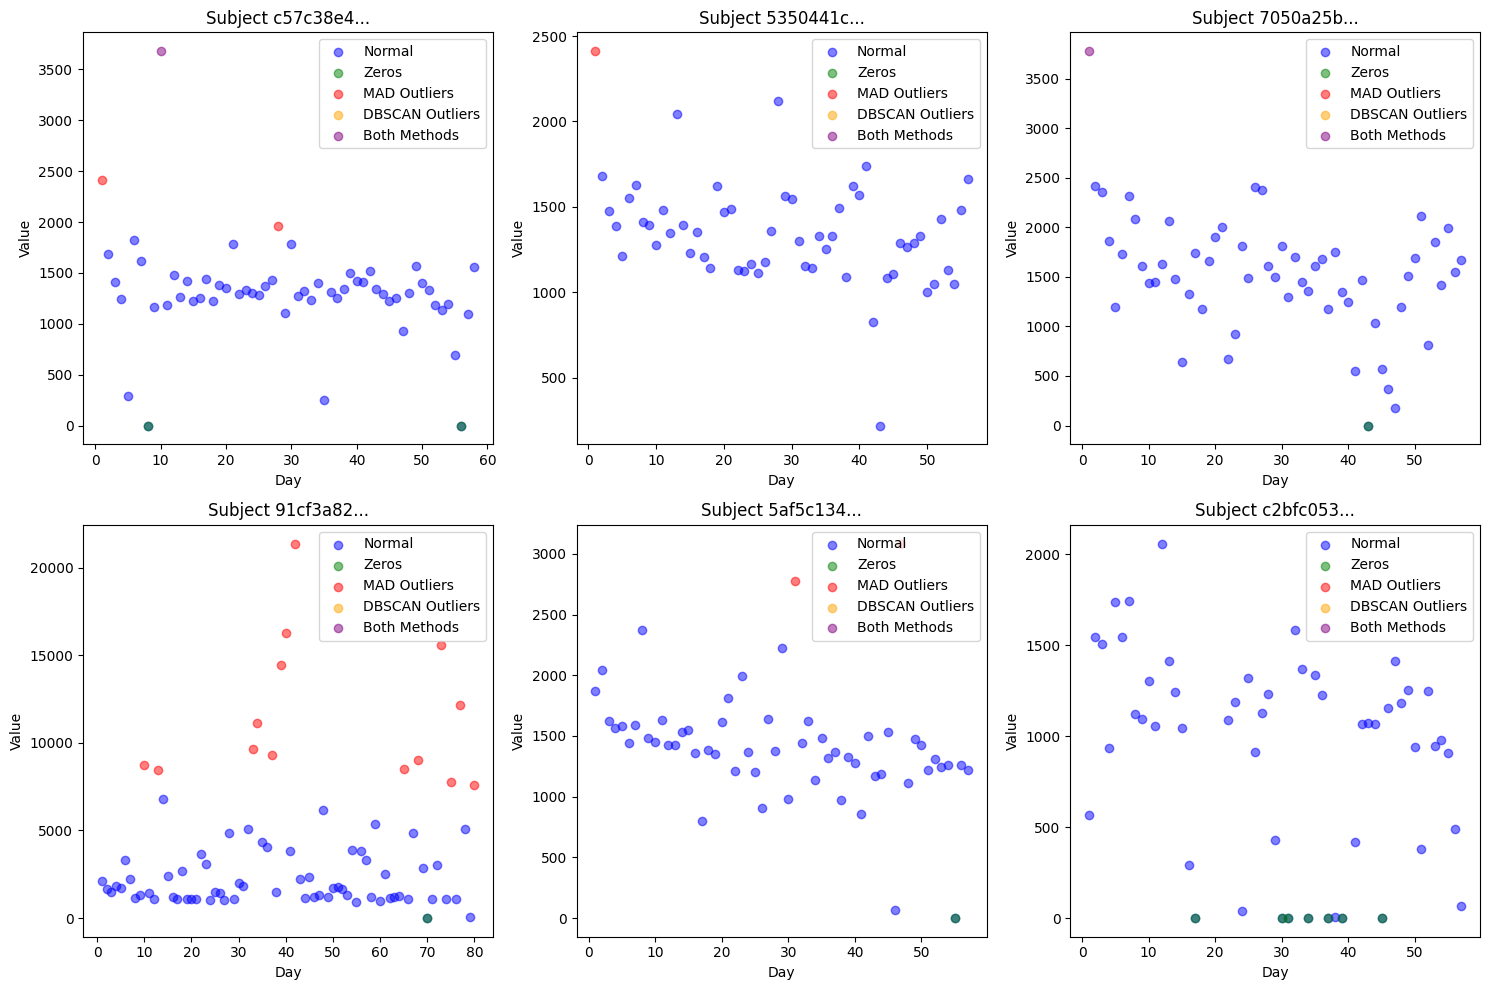


Outlier analysis for passive_sk_device_total_usage_health_and_fitness:

Subject-level statistics:
Number of subjects with MAD outliers: 71
Percentage of subjects with MAD outliers: 67.6%
Number of subjects with DBSCAN outliers: 24
Percentage of subjects with DBSCAN outliers: 22.9%
Number of subjects with outliers from both methods: 21
Percentage of subjects with outliers from both methods: 20.0%

Datapoint-level statistics:
Total number of datapoints: 6541
Total MAD outliers: 167
Percentage of MAD outliers: 2.6%
Total DBSCAN outliers: 30
Percentage of DBSCAN outliers: 0.5%
Total outliers identified by both methods: 25
Percentage of outliers identified by both methods: 0.4%


In [59]:
# Plot outliers for 6 subjects (1 specific + 5 random) using MAD and DBSCAN methods
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import median_abs_deviation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

col = 'passive_sk_device_total_usage_health_and_fitness'

eps_value = 2

# Get specific subject and 5 random subjects
specific_subject = 'c57c38e4-e887-40d2-ab8b-8ae62f5dfaa8'
other_subjects = list(set(df_cleaned['PID'].unique()) - {specific_subject})
random_subjects = random.sample(other_subjects, 5)
subjects_to_plot = [specific_subject] + random_subjects

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot data for each subject
for idx, pid in enumerate(subjects_to_plot):
    mask = df_cleaned['PID'] == pid
    subject_data = df_cleaned.loc[mask, [col, 'day']]
    
    # Drop NaN values
    subject_data = subject_data.dropna()
    
    # MAD outlier detection on non-zero values only
    non_zero_data = subject_data[subject_data[col] > 0][col]
    if len(non_zero_data) > 0:
        median = non_zero_data.median()
        mad = median_abs_deviation(non_zero_data, scale='normal', nan_policy='omit')
        outlier_mask_mad = (subject_data[col] > (median + 4 * mad)) & (subject_data[col] > 0)
    else:
        outlier_mask_mad = np.zeros(len(subject_data), dtype=bool)
    
    # DBSCAN outlier detection
    X = subject_data[[col]].values
    if len(X) > 0:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        dbscan = DBSCAN(eps=eps_value, min_samples=3)
        labels = dbscan.fit_predict(X_scaled)
        outlier_mask_dbscan = labels == -1
    else:
        outlier_mask_dbscan = np.zeros(len(subject_data), dtype=bool)
    
    # Find points that are outliers in both methods
    both_outliers = outlier_mask_mad & outlier_mask_dbscan
    
    # Plot normal points (non-outliers)
    normal_mask = ~outlier_mask_mad & ~outlier_mask_dbscan
    axes[idx].scatter(subject_data.loc[normal_mask, 'day'], 
                     subject_data.loc[normal_mask, col],
                     c='blue', alpha=0.5, label='Normal')
    
    # Plot zeros separately
    zero_mask = subject_data[col] == 0
    axes[idx].scatter(subject_data.loc[zero_mask, 'day'],
                     subject_data.loc[zero_mask, col],
                     c='green', alpha=0.5, label='Zeros')
    
    # Plot MAD outliers
    mad_only = outlier_mask_mad & ~outlier_mask_dbscan
    axes[idx].scatter(subject_data.loc[mad_only, 'day'],
                     subject_data.loc[mad_only, col],
                     c='red', alpha=0.5, label='MAD Outliers')
    
    # Plot DBSCAN outliers
    dbscan_only = outlier_mask_dbscan & ~outlier_mask_mad
    axes[idx].scatter(subject_data.loc[dbscan_only, 'day'],
                     subject_data.loc[dbscan_only, col],
                     c='orange', alpha=0.5, label='DBSCAN Outliers')
    
    # Plot points identified by both methods
    axes[idx].scatter(subject_data.loc[both_outliers, 'day'],
                     subject_data.loc[both_outliers, col],
                     c='purple', alpha=0.5, label='Both Methods')
    
    axes[idx].set_title(f'Subject {pid[:8]}...')
    axes[idx].set_ylabel('Value')
    axes[idx].set_xlabel('Day')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nOutlier analysis for {col}:")

# Initialize counters
total_outliers_mad = 0
total_outliers_dbscan = 0
total_outliers_both = 0
total_datapoints = 0
subjects_with_outliers_mad = 0
subjects_with_outliers_dbscan = 0
subjects_with_outliers_both = 0

for pid in df_cleaned['PID'].unique():
    subject_data = df_cleaned.loc[df_cleaned['PID'] == pid, [col, 'day']].dropna()
    total_datapoints += len(subject_data)
    
    # MAD outliers on non-zero values
    non_zero_data = subject_data[subject_data[col] > 0][col]
    if len(non_zero_data) > 0:
        median = non_zero_data.median()
        mad = median_abs_deviation(non_zero_data, scale='normal', nan_policy='omit')
        outliers_mad = (subject_data[col] > (median + 4 * mad)) & (subject_data[col] > 0)
        
        # DBSCAN outliers
        X = subject_data[[col]].values
        if len(X) > 0:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            dbscan = DBSCAN(eps=eps_value, min_samples=3)
            labels = dbscan.fit_predict(X_scaled)
            outliers_dbscan = labels == -1
        else:
            outliers_dbscan = np.zeros(len(subject_data), dtype=bool)
        
        # Both methods
        outliers_both = outliers_mad & outliers_dbscan
        
        if any(outliers_mad):
            subjects_with_outliers_mad += 1
        if any(outliers_dbscan):
            subjects_with_outliers_dbscan += 1
        if any(outliers_both):
            subjects_with_outliers_both += 1
            
        total_outliers_mad += sum(outliers_mad)
        total_outliers_dbscan += sum(outliers_dbscan)
        total_outliers_both += sum(outliers_both)

total_subjects = len(df_cleaned['PID'].unique())

print("\nSubject-level statistics:")
print(f"Number of subjects with MAD outliers: {subjects_with_outliers_mad}")
print(f"Percentage of subjects with MAD outliers: {(subjects_with_outliers_mad / total_subjects) * 100:.1f}%")
print(f"Number of subjects with DBSCAN outliers: {subjects_with_outliers_dbscan}")
print(f"Percentage of subjects with DBSCAN outliers: {(subjects_with_outliers_dbscan / total_subjects) * 100:.1f}%")
print(f"Number of subjects with outliers from both methods: {subjects_with_outliers_both}")
print(f"Percentage of subjects with outliers from both methods: {(subjects_with_outliers_both / total_subjects) * 100:.1f}%")

print("\nDatapoint-level statistics:")
print(f"Total number of datapoints: {total_datapoints}")
print(f"Total MAD outliers: {total_outliers_mad}")
print(f"Percentage of MAD outliers: {(total_outliers_mad / total_datapoints) * 100:.1f}%")
print(f"Total DBSCAN outliers: {total_outliers_dbscan}")
print(f"Percentage of DBSCAN outliers: {(total_outliers_dbscan / total_datapoints) * 100:.1f}%")
print(f"Total outliers identified by both methods: {total_outliers_both}")
print(f"Percentage of outliers identified by both methods: {(total_outliers_both / total_datapoints) * 100:.1f}%")


### Remove Outliers

In [60]:
# Apply outlier detection to all 'passive_' columns
passive_columns = [col for col in df_cleaned.columns if col.startswith('passive_')]

# Initialize counters for overall statistics and per-variable tracking
total_datapoints = 0
total_outliers_mad = 0
total_outliers_dbscan = 0
total_outliers_both = 0

# Dictionary to track outlier percentages per variable
var_outliers = {}

# Create copy of dataframe to remove outliers from
df_cleaned_no_outliers = df_cleaned.copy()

# Process each column
for col in passive_columns:
    # Skip columns that are all NaN
    if df_cleaned[col].isna().all():
        continue
        
    col_datapoints = 0
    col_outliers_mad = 0
    col_outliers_dbscan = 0
    col_outliers_both = 0
    
    # Process each subject separately
    for pid in df_cleaned['PID'].unique():
        subject_data = df_cleaned.loc[df_cleaned['PID'] == pid, [col, 'day']].dropna()
        
        if len(subject_data) == 0:
            continue
            
        col_datapoints += len(subject_data)
        
        # MAD outliers on non-zero values
        non_zero_data = subject_data[subject_data[col] > 0][col]
        if len(non_zero_data) > 0:
            median = non_zero_data.median()
            mad = median_abs_deviation(non_zero_data, scale='normal', nan_policy='omit')
            outliers_mad = (subject_data[col] > (median + 4 * mad)) & (subject_data[col] > 0)
            
            # DBSCAN outliers
            X = subject_data[['day', col]].values
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            dbscan = DBSCAN(eps=2, min_samples=3)
            labels = dbscan.fit_predict(X_scaled)
            outliers_dbscan = labels == -1
            
            # Both methods
            outliers_both = outliers_mad & outliers_dbscan
            
            # Update column counters
            col_outliers_mad += sum(outliers_mad)
            col_outliers_dbscan += sum(outliers_dbscan)
            col_outliers_both += sum(outliers_both)
            
            # Set outlier values to NaN in cleaned dataframe
            outlier_indices = subject_data[outliers_both].index
            df_cleaned_no_outliers.loc[outlier_indices, col] = np.nan
    
    # Store percentages for this variable
    if col_datapoints > 0:
        var_outliers[col] = {
            'mad_pct': (col_outliers_mad / col_datapoints) * 100,
            'dbscan_pct': (col_outliers_dbscan / col_datapoints) * 100,
            'both_pct': (col_outliers_both / col_datapoints) * 100
        }
    
    # Update total counters
    total_datapoints += col_datapoints
    total_outliers_mad += col_outliers_mad
    total_outliers_dbscan += col_outliers_dbscan
    total_outliers_both += col_outliers_both

# Find variable with highest combined outlier percentage
max_var = max(var_outliers.items(), key=lambda x: x[1]['both_pct'])

# Print summary statistics
print("\nOutlier Detection Summary:")
print(f"Total datapoints analyzed: {total_datapoints}")
print(f"\nMAD method only:")
print(f"Total outliers: {total_outliers_mad}")
print(f"Percentage: {(total_outliers_mad / total_datapoints) * 100:.2f}%")
print(f"\nDBSCAN method only:")
print(f"Total outliers: {total_outliers_dbscan}")
print(f"Percentage: {(total_outliers_dbscan / total_datapoints) * 100:.2f}%")
print(f"\nBoth methods combined:")
print(f"Total outliers: {total_outliers_both}")
print(f"Percentage: {(total_outliers_both / total_datapoints) * 100:.2f}%")

print(f"\nVariable with highest proportion of outliers: {max_var[0]}")
print(f"MAD outliers: {max_var[1]['mad_pct']:.2f}%")
print(f"DBSCAN outliers: {max_var[1]['dbscan_pct']:.2f}%") 
print(f"Combined outliers: {max_var[1]['both_pct']:.2f}%")



Outlier Detection Summary:
Total datapoints analyzed: 501564

MAD method only:
Total outliers: 13546
Percentage: 2.70%

DBSCAN method only:
Total outliers: 3506
Percentage: 0.70%

Both methods combined:
Total outliers: 2357
Percentage: 0.47%

Variable with highest proportion of outliers: passive_sk_visits_school_distance
MAD outliers: 9.09%
DBSCAN outliers: 4.55%
Combined outliers: 4.55%


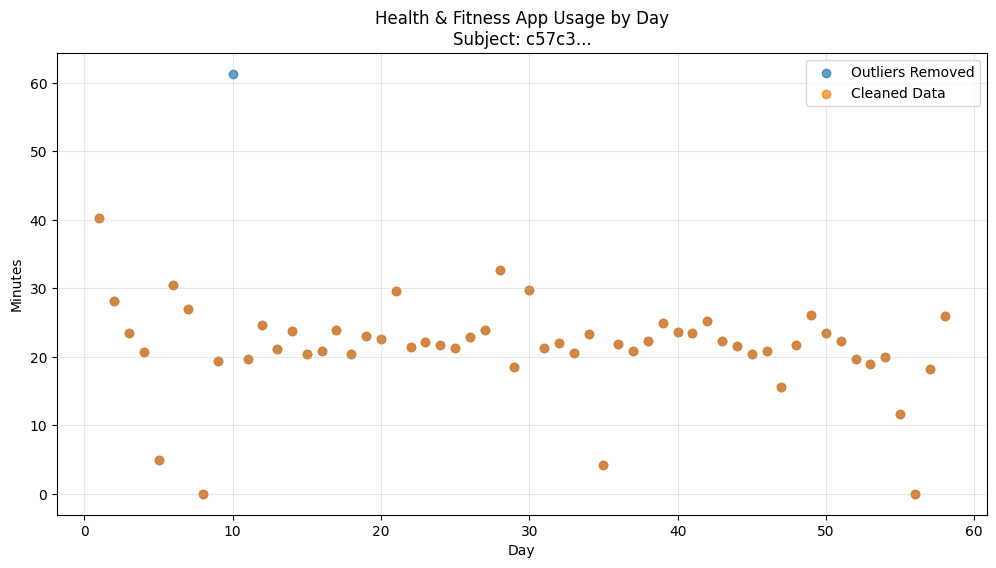

In [61]:
# Plot health and fitness usage for specific subject, comparing original vs outlier-removed data
subject_id = 'c57c38e4-e887-40d2-ab8b-8ae62f5dfaa8'

fig, ax = plt.subplots(figsize=(12,6))

# Plot original data
subject_data = df_cleaned[df_cleaned['PID'] == subject_id]
plt.scatter(subject_data['day'], 
           subject_data['passive_sk_device_total_usage_health_and_fitness']/60,
           label='Outliers Removed',
           alpha=0.7)

# Plot data with outliers removed
subject_data_clean = df_cleaned_no_outliers[df_cleaned_no_outliers['PID'] == subject_id]
plt.scatter(subject_data_clean['day'],
           subject_data_clean['passive_sk_device_total_usage_health_and_fitness']/60,
           label='Cleaned Data', 
           alpha=0.7)

plt.title(f'Health & Fitness App Usage by Day\nSubject: c57c3...')
plt.xlabel('Day')
plt.ylabel('Minutes')
plt.legend()
plt.grid(True, alpha=0.3)

In [62]:
# Count values of passive_sk_device_total_usage_weather above 3600
weather_high_count = len(df_cleaned[df_cleaned['passive_sk_device_total_usage_news'] > 3600])
print(f"Number of values above 3600 in passive_sk_device_total_usage_weather: {weather_high_count}")

Number of values above 3600 in passive_sk_device_total_usage_weather: 474


In [ ]:
# Save df_cleaned_no_outliers to CSV
df_cleaned_no_outliers.to_csv('../../02_analysis/df_cleaned_no_outliers.csv', index=False)

## Filter Features

Filter df to include only rows with day values between 5 and 81

We noted some extreme/odd values in the initial days of the study as people learned the tasks/interface. We also saw some odd values in the final days of the study as people completed the study.

In [123]:
# filter days
filter_start_day = 5
filter_end_day = 81

In [124]:
# Filter df to include only rows with day values between 5 and 81
df_filtered = df_cleaned_no_outliers[(df_cleaned_no_outliers['day'] >= filter_start_day) & (df_cleaned_no_outliers['day'] <= filter_end_day)]

# Reset the index after filtering
df_filtered.reset_index(drop=True, inplace=True)

print(f"Filtered dataframe to include only days {filter_start_day}-{filter_end_day}.\nOld shape: {df.shape}\nNew shape: {df_filtered.shape}")

Filtered dataframe to include only days 5-81.
Old shape: (8925, 342)
New shape: (8085, 342)


## Detrend Features

Examples of reasons for detrending...

**Digital Trace Data**

In [65]:
# Digital Trace Data Example LMM
import statsmodels.formula.api as smf

# Prepare data
model_data = df_cleaned_no_outliers[['passive_sk_device_total_usage_health_and_fitness', 'day', 'PID']]
model_data = model_data.dropna()

# Scale the outcome variable within each subject for better model convergence
model_data['health_fitness_scaled'] = model_data.groupby('PID')['passive_sk_device_total_usage_health_and_fitness'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Fit model with more stable settings
md = smf.mixedlm("health_fitness_scaled ~ 0 + day",
                 model_data,
                 groups=model_data["PID"],
                 re_formula="0 + day") 

# Try fitting with different optimizers and settings
try:
    mdf = md.fit(method='lbfgs',
                 maxiter=1000,
                 start_params=None,
                 full_output=True)
    print(mdf.summary())
except:
    print("Model failed to converge with lbfgs")
    try:
        # Try alternate optimizer
        mdf = md.fit(method='nm',
                    maxiter=1000,
                    full_output=True)
        print(mdf.summary())
    except:
        print("Model failed to converge with both optimizers")

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: health_fitness_scaled
No. Observations: 6510    Method:             REML                 
No. Groups:       105     Scale:              0.9893               
Min. group size:  39      Log-Likelihood:     -9209.0990           
Max. group size:  84      Converged:          Yes                  
Mean group size:  62.0                                             
----------------------------------------------------------------------
            Coef.     Std.Err.       z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------
day         -0.006       0.001    -12.108    0.000    -0.007    -0.005
day Var      0.000       0.000                                        



/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


**Self-Report Data**

In [66]:
# Self-Report Data Example LMM

import statsmodels.formula.api as smf

# Prepare data
model_data = df_cleaned_no_outliers[['sr_gap_heuristic', 'day', 'PID']]
model_data = model_data.dropna()

# Scale the outcome variable within each subject for better model convergence
model_data['sr_gap_scaled'] = model_data.groupby('PID')['sr_gap_heuristic'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Fit model with more stable settings
md = smf.mixedlm("sr_gap_scaled ~ 0 + day",
                 model_data,
                 groups=model_data["PID"],
                 re_formula="0 + day") 

# Try fitting with different optimizers and settings
try:
    mdf = md.fit(method='lbfgs',
                 maxiter=1000,
                 start_params=None,
                 full_output=True)
    print(mdf.summary())
except:
    print("Model failed to converge with lbfgs")
    try:
        # Try alternate optimizer
        mdf = md.fit(method='nm',
                    maxiter=1000,
                    full_output=True)
        print(mdf.summary())
    except:
        print("Model failed to converge with both optimizers")

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_scaled
No. Observations: 8068    Method:             REML         
No. Groups:       105     Scale:              0.9982       
Min. group size:  45      Log-Likelihood:     -11447.4724  
Max. group size:  84      Converged:          Yes          
Mean group size:  76.8                                     
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
day          -0.003     0.000  -7.594  0.000  -0.004  -0.002
day Var       0.000     0.000                               



/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


---

**Note**: Oddly this goes in the opposite direction if we use the filtered data?

WHY?

Average regression coeffient is still negative across subjects...

In [251]:
# Get coefficients for health and fitness app usage over time
results_df = pd.DataFrame()

# First get coefficients from filtered data
model_data = df_filtered[['passive_sk_device_total_usage_health_and_fitness', 'day', 'PID']]
model_data = model_data.dropna()

# Scale within subjects
model_data['health_scaled'] = model_data.groupby('PID')['passive_sk_device_total_usage_health_and_fitness'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Get coefficients for each subject
coefs_filtered = []
for pid in model_data.PID.unique():
    subject_data = model_data[model_data.PID == pid]
    try:
        model = smf.ols('health_scaled ~ day', data=subject_data).fit()
        coefs_filtered.append({'PID': pid, 'coef_filtered': model.params['day']})
    except:
        continue
        
# Now get coefficients from cleaned data
model_data = df_cleaned_no_outliers[['passive_sk_device_total_usage_health_and_fitness', 'day', 'PID']]
model_data = model_data.dropna()

model_data['health_scaled'] = model_data.groupby('PID')['passive_sk_device_total_usage_health_and_fitness'].transform(
    lambda x: (x - x.mean()) / x.std()
)

coefs_cleaned = []
for pid in model_data.PID.unique():
    subject_data = model_data[model_data.PID == pid]
    try:
        model = smf.ols('health_scaled ~ day', data=subject_data).fit()
        coefs_cleaned.append({'PID': pid, 'coef_cleaned': model.params['day']})
    except:
        continue

# Combine into single dataframe
filtered_df = pd.DataFrame(coefs_filtered)
cleaned_df = pd.DataFrame(coefs_cleaned)

coefs_df = filtered_df.merge(cleaned_df, on='PID', how='outer')

# Print summary statistics
print("\nSummary Statistics:")
coefs_df.describe()



Summary Statistics:


,coef_filtered,coef_cleaned
count,105.000000,105.000000
mean,-0.009427,-0.012576
std,0.015978,0.014635
min,-0.046808,-0.042117
25%,-0.018197,-0.020713
50%,-0.009847,-0.013266
75%,-0.000078,-0.004511
max,0.048284,0.048284


**Task Data**

In [67]:
# Task Data Example LMM - Hanoi number of moves

import statsmodels.formula.api as smf

# Prepare data
model_data = df_cleaned_no_outliers[['task_hanoi_moves', 'day', 'PID']]
model_data = model_data.dropna().reset_index(drop=True)

# Scale the outcome variable within each subject for better model convergence
model_data['hanoi_scaled'] = model_data.groupby('PID')['task_hanoi_moves'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Introduced NAs so remove again
model_data = model_data.dropna().reset_index(drop=True)

# Create copy of data to avoid fragmentation
model_data = model_data.copy()

# Fit model with more stable settings
md = smf.mixedlm("hanoi_scaled ~ 0 + day",
                    model_data,
                    groups=model_data["PID"],
                    re_formula="0 + day")

# Try fitting with different optimizers and settings
try:
    mdf = md.fit(method='lbfgs',
                    maxiter=1000,
                    start_params=None,
                    full_output=True)
    print(mdf.summary())
except:
    print("Model failed to converge with lbfgs")
    try:
        # Try alternate optimizer
        mdf = md.fit(method='nm',
                    maxiter=1000,
                    full_output=True)
        print(mdf.summary())
    except:
        print("Model failed to converge with both optimizers")

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: hanoi_scaled
No. Observations: 6946    Method:             REML        
No. Groups:       100     Scale:              1.0023      
Min. group size:  9       Log-Likelihood:     -9870.8741  
Max. group size:  84      Converged:          Yes         
Mean group size:  69.5                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
day         -0.010     0.002  -5.294  0.000  -0.013  -0.006
day Var      0.000     0.000                               



/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<div class="alert alert-warning">
<h3>⚠️ Detrending Note</h3>
<p>When there are many successive zero values, especially at the beginning or end of the data, this tends to lead to a "trend" being inserted into the zero values...this could make sense in the context of "not" doing something haveing less effect on other variables with each successive day that you do <b>not</b> do it (i.e. starts to become your new normal)...</p>
</div>


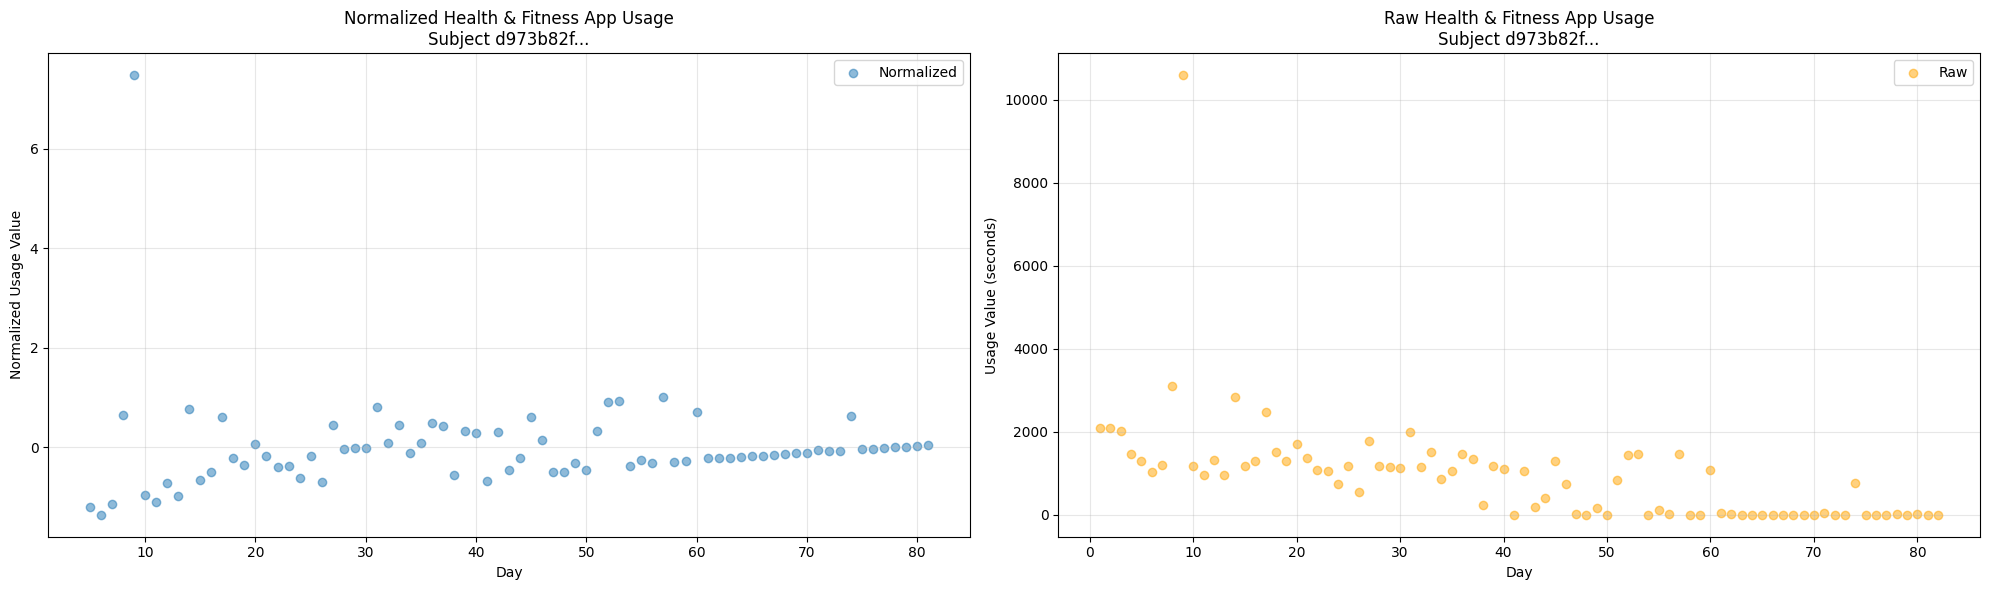

In [ ]:
# Visualize Detrending Issue with non-random zero inflated data

# Plot health and fitness usage for specific subject using both normalized and raw data
subject_id = 'd973b82f-367b-4871-94a9-181421f870e8'
subject_data_norm = df_passive_normalized[df_passive_normalized['PID'] == subject_id]
subject_data_raw = df_cleaned[df_cleaned['PID'] == subject_id]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot normalized data
ax1.scatter(subject_data_norm['day'], subject_data_norm['passive_sk_device_total_usage_health_and_fitness'], 
           alpha=0.5, label='Normalized')
ax1.set_title(f'Normalized Health & Fitness App Usage\nSubject {subject_id[:8]}...')
ax1.set_ylabel('Normalized Usage Value')
ax1.set_xlabel('Day')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot raw data
ax2.scatter(subject_data_raw['day'], subject_data_raw['passive_sk_device_total_usage_health_and_fitness'],
           alpha=0.5, color='orange', label='Raw')
ax2.set_title(f'Raw Health & Fitness App Usage\nSubject {subject_id[:8]}...')
ax2.set_ylabel('Usage Value (seconds)')
ax2.set_xlabel('Day') 
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


Select relevant columns and detrend...

In [125]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

unnecessary_id_cols = [
    'PID',
    'day',
]

# Binary cols
binary_cols = [
    'task_hanoi_solved',
    'task_emoStroop_trying',
    'task_gng_trying',
    'task_nback_mode_hard',
    'survey_complete',
    'tasks_complete',
    'watch_wearing',
    'weekend',
    'day_of_week_0',
    'day_of_week_1',
    'day_of_week_2',
    'day_of_week_3',
    'day_of_week_4',
    'day_of_week_5',
    'day_of_week_6'
    ]

# Get columns to detrend
columns_to_detrend = [col for col in df_filtered.columns if col not in binary_cols + unnecessary_id_cols]

# Function to detrend a single column
def detrend_column(group):
    X = np.arange(len(group))
    X_poly = np.column_stack((X, X**2, X**3))
    
    # Remove NaN and infinite values
    mask = ~np.isnan(group) & ~np.isinf(group)
    X_clean = X_poly[mask]
    y_clean = group[mask]
    
    if len(y_clean) > 0:
        model = LinearRegression().fit(X_clean, y_clean)
        trend = np.full(len(group), np.nan)
        trend[mask] = model.predict(X_clean)
        return group - trend
    else:
        return group  # Return original if all values are NaN or infinite

# Prepare a dictionary to store detrended columns
detrended_data = {col: df_filtered[col] for col in unnecessary_id_cols + binary_cols}

# Detrend each column
for col in columns_to_detrend:
    if np.issubdtype(df_filtered[col].dtype, np.number):  # Check if column is numeric
        try:
            detrended_data[col] = df_filtered.groupby('PID')[col].transform(detrend_column)
        except ValueError as e:
            print(f"Error in column {col}: {str(e)}")
            detrended_data[col] = df_filtered[col]  # Keep original if error occurs
    else:
        detrended_data[col] = df_filtered[col]  # Keep non-numeric columns as is

# Create the detrended dataframe using pd.concat
df_detrended = pd.concat(detrended_data, axis=1)

print(f"Detrended {len(columns_to_detrend)} columns")


Detrended 325 columns


### Visualize Detrending

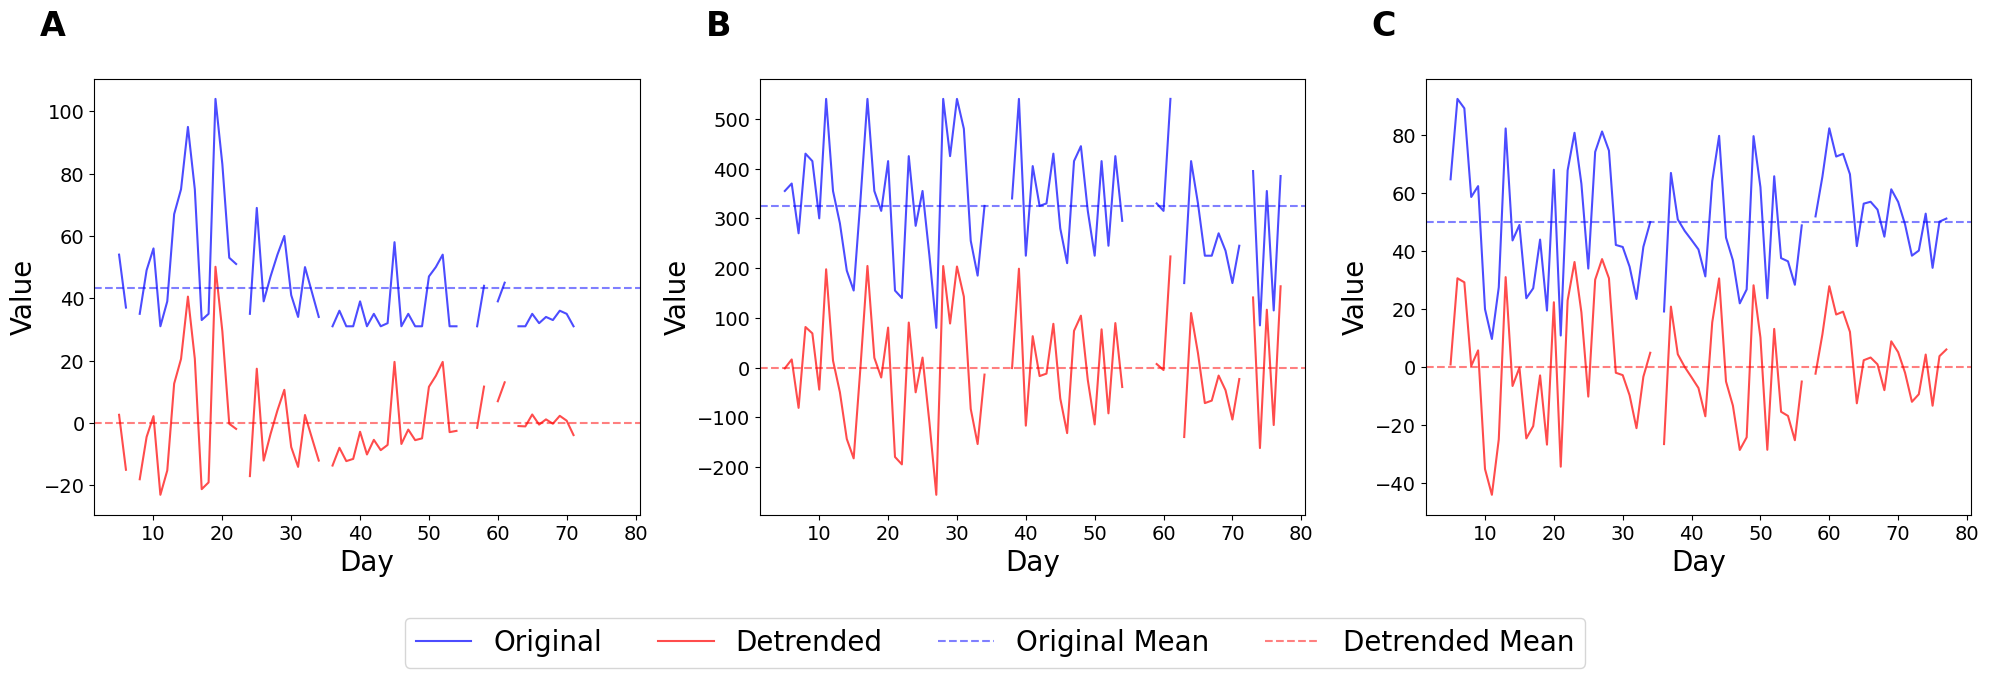

Plotted comparison for PID: fb6c8f5a-f92d-4af8-9f87-73ffd4e21f98
Columns plotted: ['task_hanoi_moves', 'task_spatialSpan_score', 'sr_gap_heuristic']


In [79]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Select a random PID
random_pid = random.choice(df_filtered['PID'].unique())
random_pid = 'fb6c8f5a-f92d-4af8-9f87-73ffd4e21f98'

# Specify the columns to plot
columns_to_plot = ['task_hanoi_moves', 'task_spatialSpan_score', 'sr_gap_heuristic']

# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, col in enumerate(columns_to_plot):
    # Filter data for the selected PID
    original_data = df_filtered[df_filtered['PID'] == random_pid]
    detrended_data = df_detrended[df_detrended['PID'] == random_pid]
    
    # Plot original data
    axs[i].plot(original_data['day'], original_data[col], label='Original', color='blue', alpha=0.7)
    
    # Plot detrended data
    axs[i].plot(detrended_data['day'], detrended_data[col], label='Detrended', color='red', alpha=0.7)
    
    # Add horizontal lines at the mean for both original and detrended data
    original_mean = np.mean(original_data[col])
    detrended_mean = np.mean(detrended_data[col])
    axs[i].axhline(y=original_mean, color='blue', linestyle='--', alpha=0.5, label='Original Mean')
    axs[i].axhline(y=detrended_mean, color='red', linestyle='--', alpha=0.5, label='Detrended Mean')
    
    axs[i].set_xlabel('Day', fontsize=20)
    axs[i].set_ylabel('Value', fontsize=20)
    axs[i].text(-0.1, 1.1, chr(65+i), transform=axs[i].transAxes, size=24, weight='bold')
    
    # Increase tick label size
    axs[i].tick_params(axis='both', which='major', labelsize=14)

# Create a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -.15), ncol=4, fontsize=20)

plt.tight_layout()
plt.show()

print(f"Plotted comparison for PID: {random_pid}")
print(f"Columns plotted: {columns_to_plot}")

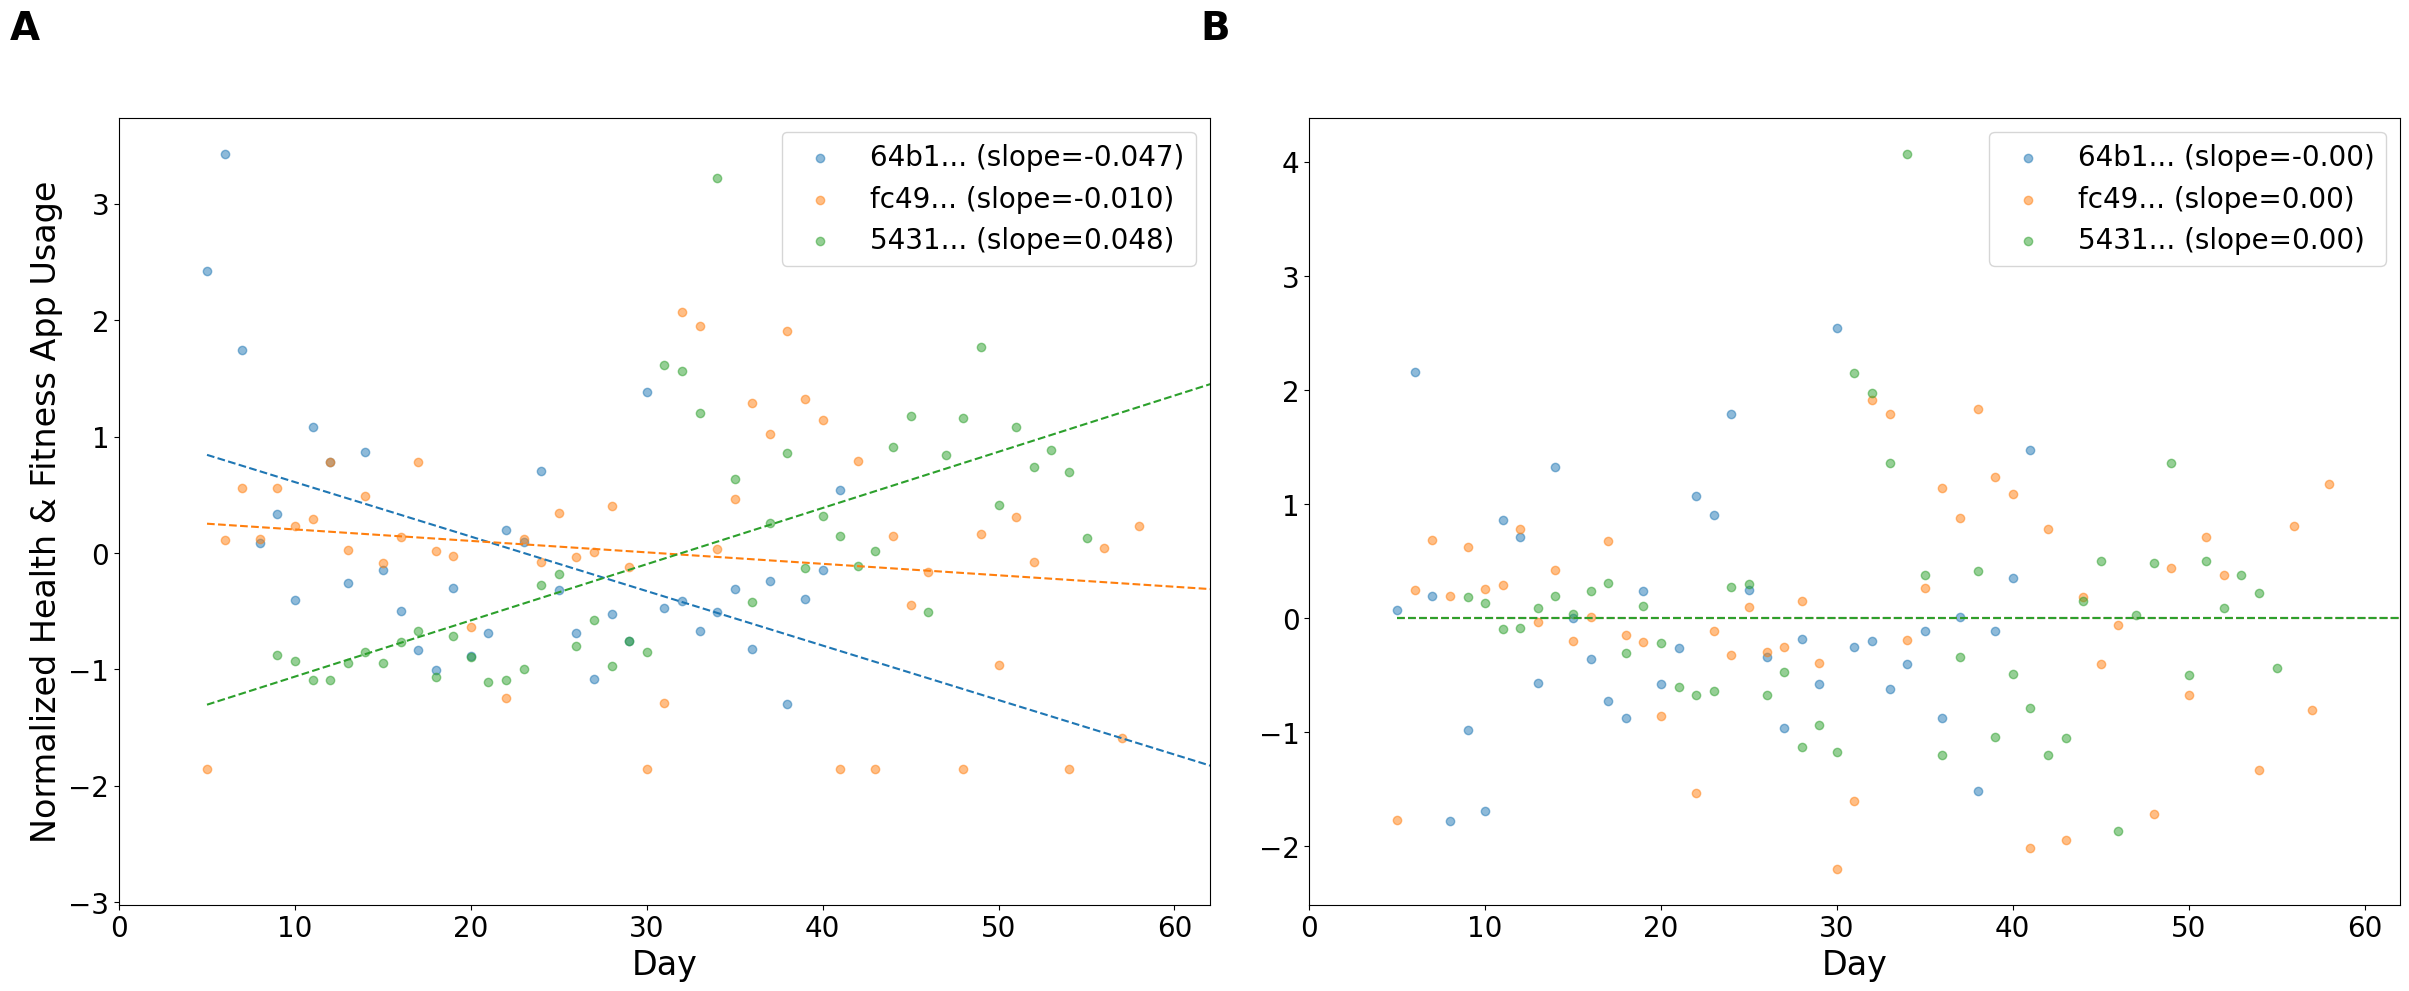

In [263]:
# Get regression coefficients for each PID
regression_coefs = pd.DataFrame()

for pid in df_filtered['PID'].unique():
    # Get data for this PID
    pid_data = df_filtered[df_filtered['PID'] == pid].copy()  # Create copy to avoid warning
    
    # Only proceed if we have enough data points
    if len(pid_data) > 2:
        # Normalize health & fitness usage for this PID
        pid_data.loc[:, 'health_fitness_norm'] = (pid_data['passive_sk_device_total_usage_health_and_fitness'] - 
                                         pid_data['passive_sk_device_total_usage_health_and_fitness'].mean()) / \
                                        pid_data['passive_sk_device_total_usage_health_and_fitness'].std()
        
        # Fit linear regression on normalized data
        model = smf.ols('health_fitness_norm ~ day', data=pid_data).fit()
        regression_coefs.loc[pid, 'coef'] = model.params['day']

# Sort coefficients and get extreme and median PIDs
sorted_coefs = regression_coefs.sort_values('coef')
min_pid = sorted_coefs.index[0]
max_pid = sorted_coefs.index[-1]
median_idx = len(sorted_coefs) // 2
median_pid = sorted_coefs.index[median_idx]

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))

# First subplot - Original data
# Plot min coefficient PID
pid_data = df_filtered[df_filtered['PID'] == min_pid].copy()  # Create copy
pid_data.loc[:, 'health_fitness_norm'] = (pid_data['passive_sk_device_total_usage_health_and_fitness'] - 
                                  pid_data['passive_sk_device_total_usage_health_and_fitness'].mean()) / \
                                 pid_data['passive_sk_device_total_usage_health_and_fitness'].std()
ax1.scatter(pid_data['day'], pid_data['health_fitness_norm'], 
           alpha=0.5, label=f'{min_pid[:4]}... (slope={sorted_coefs.loc[min_pid,"coef"]:.3f})')
model = smf.ols('health_fitness_norm ~ day', data=pid_data).fit()
ax1.plot(pid_data['day'], model.predict(pid_data), '--')

# Plot median coefficient PID
pid_data = df_filtered[df_filtered['PID'] == median_pid].copy()  # Create copy
pid_data.loc[:, 'health_fitness_norm'] = (pid_data['passive_sk_device_total_usage_health_and_fitness'] - 
                                  pid_data['passive_sk_device_total_usage_health_and_fitness'].mean()) / \
                                 pid_data['passive_sk_device_total_usage_health_and_fitness'].std()
ax1.scatter(pid_data['day'], pid_data['health_fitness_norm'],
           alpha=0.5, label=f'{median_pid[:4]}... (slope={sorted_coefs.loc[median_pid,"coef"]:.3f})')
model = smf.ols('health_fitness_norm ~ day', data=pid_data).fit()
ax1.plot(pid_data['day'], model.predict(pid_data), '--')

# Plot max coefficient PID
pid_data = df_filtered[df_filtered['PID'] == max_pid].copy()  # Create copy
pid_data.loc[:, 'health_fitness_norm'] = (pid_data['passive_sk_device_total_usage_health_and_fitness'] - 
                                  pid_data['passive_sk_device_total_usage_health_and_fitness'].mean()) / \
                                 pid_data['passive_sk_device_total_usage_health_and_fitness'].std()
ax1.scatter(pid_data['day'], pid_data['health_fitness_norm'],
           alpha=0.5, label=f'{max_pid[:4]}... (slope={sorted_coefs.loc[max_pid,"coef"]:.3f})')
model = smf.ols('health_fitness_norm ~ day', data=pid_data).fit()
ax1.plot(pid_data['day'], model.predict(pid_data), '--')

ax1.set_xlabel('Day', fontsize=24)
ax1.set_ylabel('Normalized Health & Fitness App Usage', fontsize=24)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, size=28, weight='bold')
ax1.set_xlim(0, 62)
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

# Second subplot - Detrended data
# Calculate detrended slopes
detrended_coefs = pd.DataFrame()
for pid in [min_pid, median_pid, max_pid]:
    pid_data = df_detrended[df_detrended['PID'] == pid].copy()
    pid_data.loc[:, 'health_fitness_norm'] = (pid_data['passive_sk_device_total_usage_health_and_fitness'] - 
                                     pid_data['passive_sk_device_total_usage_health_and_fitness'].mean()) / \
                                    pid_data['passive_sk_device_total_usage_health_and_fitness'].std()
    model = smf.ols('health_fitness_norm ~ day', data=pid_data).fit()
    detrended_coefs.loc[pid, 'coef'] = model.params['day']

# Plot min coefficient PID
pid_data = df_detrended[df_detrended['PID'] == min_pid].copy()
pid_data.loc[:, 'health_fitness_norm'] = (pid_data['passive_sk_device_total_usage_health_and_fitness'] - 
                                  pid_data['passive_sk_device_total_usage_health_and_fitness'].mean()) / \
                                 pid_data['passive_sk_device_total_usage_health_and_fitness'].std()
ax2.scatter(pid_data['day'], pid_data['health_fitness_norm'], 
           alpha=0.5, label=f'{min_pid[:4]}... (slope={detrended_coefs.loc[min_pid,"coef"]:.2f})')
model = smf.ols('health_fitness_norm ~ day', data=pid_data).fit()
ax2.plot(pid_data['day'], model.predict(pid_data), '--')

# Plot median coefficient PID
pid_data = df_detrended[df_detrended['PID'] == median_pid].copy()
pid_data.loc[:, 'health_fitness_norm'] = (pid_data['passive_sk_device_total_usage_health_and_fitness'] - 
                                  pid_data['passive_sk_device_total_usage_health_and_fitness'].mean()) / \
                                 pid_data['passive_sk_device_total_usage_health_and_fitness'].std()
ax2.scatter(pid_data['day'], pid_data['health_fitness_norm'],
           alpha=0.5, label=f'{median_pid[:4]}... (slope={detrended_coefs.loc[median_pid,"coef"]:.2f})')
model = smf.ols('health_fitness_norm ~ day', data=pid_data).fit()
ax2.plot(pid_data['day'], model.predict(pid_data), '--')

# Plot max coefficient PID
pid_data = df_detrended[df_detrended['PID'] == max_pid].copy()
pid_data.loc[:, 'health_fitness_norm'] = (pid_data['passive_sk_device_total_usage_health_and_fitness'] - 
                                  pid_data['passive_sk_device_total_usage_health_and_fitness'].mean()) / \
                                 pid_data['passive_sk_device_total_usage_health_and_fitness'].std()
ax2.scatter(pid_data['day'], pid_data['health_fitness_norm'],
           alpha=0.5, label=f'{max_pid[:4]}... (slope={detrended_coefs.loc[max_pid,"coef"]:.2f})')
model = smf.ols('health_fitness_norm ~ day', data=pid_data).fit()
ax2.plot(pid_data['day'], model.predict(pid_data), '--')

ax2.set_xlabel('Day', fontsize=24)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, size=28, weight='bold')
ax2.set_xlim(0, 62)
ax2.legend(fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()

## Filter Target

In [126]:
df_target['trial_date'] = pd.to_datetime(df_target['trial_date'])
df_target['t_current'] = df['sr_gap_heuristic']
df_target['day'] = df['day']

# Filter df to include only rows with day values between 5 and 81
df_filtered_target = df_target[(df_target['day'] >= filter_start_day) & (df_target['day'] <= filter_end_day)]

# Reset the index after filtering
df_filtered_target.reset_index(drop=True, inplace=True)

## Detrend Target

In [127]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

unnecessary_id_cols = [
    'PID',
    'day',
]

# Get columns to detrend
columns_to_detrend = [col for col in df_filtered_target.columns if col not in unnecessary_id_cols]

# Function to detrend a single column
def detrend_column(group):
    X = np.arange(len(group))
    X_poly = np.column_stack((X, X**2, X**3))
    
    # Remove NaN and infinite values
    mask = ~np.isnan(group) & ~np.isinf(group)
    X_clean = X_poly[mask]
    y_clean = group[mask]
    
    if len(y_clean) > 0:
        model = LinearRegression().fit(X_clean, y_clean)
        trend = np.full(len(group), np.nan)
        trend[mask] = model.predict(X_clean)
        detrended = group - trend + np.mean(y_clean)  # Add back the original mean
        return detrended
    else:
        return group  # Return original if all values are NaN or infinite

# Prepare a dictionary to store detrended columns
detrended_data = {col: df_filtered_target[col] for col in unnecessary_id_cols}

# Detrend each column
for col in columns_to_detrend:
    if np.issubdtype(df_filtered_target[col].dtype, np.number):  # Check if column is numeric
        try:
            detrended_data[col] = df_filtered_target.groupby('PID')[col].transform(detrend_column)
        except ValueError as e:
            print(f"Error in column {col}: {str(e)}")
            detrended_data[col] = df_filtered_target[col]  # Keep original if error occurs
    else:
        detrended_data[col] = df_filtered_target[col]  # Keep non-numeric columns as is

# Create the detrended dataframe using pd.concat
df_target_detrended = pd.concat(detrended_data, axis=1)

print(f"Detrended {len(columns_to_detrend)} columns")


Detrended 5 columns


In [128]:
# Drop the 'day' column from df_target_detrended
df_target_detrended = df_target_detrended.drop(columns=['day'])

df_target_detrended.describe()

,trial_date,t_next1,t_next3,t_next3e,t_current
count,8085,7418.000000,7804.000000,7418.000000,7433.000000
mean,2023-02-02 21:42:51.428571392,41.867654,41.873218,41.792652,41.957263
min,2022-10-01 00:00:00,-18.277710,-5.325513,-4.478416,-17.338452
25%,2022-12-03 00:00:00,28.530092,32.453969,31.191285,28.634169
50%,2023-02-24 00:00:00,42.953834,43.159305,43.197113,43.069400
75%,2023-03-24 00:00:00,54.136406,51.686358,51.908253,54.363993
max,2023-04-20 00:00:00,106.376682,103.748207,103.895161,106.626794
std,NaN,19.754344,15.580382,16.180422,19.739234


**Note**

In detrending the target we have introduced negative values and values above 100 - this should not be a problem for the model, but it is something to be aware of.


Minimum value of t_current: -17.34
Maximum value of t_current: 106.63


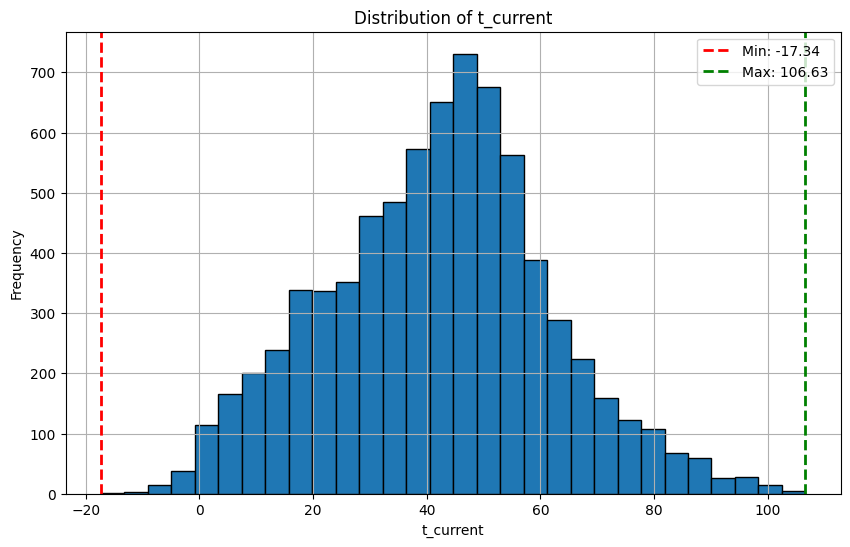

In [267]:
# Plot histogram of t_current
plt.figure(figsize=(10, 6))
df_target_detrended['t_current'].hist(bins=30, edgecolor='black')
plt.title('Distribution of t_current')
plt.xlabel('t_current')
plt.ylabel('Frequency')

# Add min and max to the plot
min_val = df_target_detrended['t_current'].min()
max_val = df_target_detrended['t_current'].max()
plt.axvline(min_val, color='r', linestyle='dashed', linewidth=2, label=f'Min: {min_val:.2f}')
plt.axvline(max_val, color='g', linestyle='dashed', linewidth=2, label=f'Max: {max_val:.2f}')
plt.legend()

# Print min and max values
print(f"Minimum value of t_current: {min_val:.2f}")
print(f"Maximum value of t_current: {max_val:.2f}")

plt.show()


In [129]:
# id_cols
id_cols = [
    'PID',
    'trial_date',
    'day',
    'cohort'
    ]

In [130]:
# Binary cols
binary_cols = [
    'task_hanoi_solved',
    'task_emoStroop_trying',
    'task_gng_trying',
    'task_nback_mode_hard',
    'survey_complete',
    'tasks_complete',
    'watch_wearing',
    'weekend',
    'day_of_week_0',
    'day_of_week_1',
    'day_of_week_2',
    'day_of_week_3',
    'day_of_week_4',
    'day_of_week_5',
    'day_of_week_6'
    ]

In [131]:
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: ['PID', 'trial_date', 'task_hanoi_solved', 'cohort']


# Passive Analysis

## Create DF

In [132]:
# Passive features
passive_cols = [col for col in df.columns if 'passive' in col]

# ID cols
id_cols = [
    'PID',
    'trial_date',
    'day',
    'cohort'
    ]

# Additional cols
additional_cols = [
    'task_duration',
    'task_start_time',
    'task_end_time',
    'css',
    'survey_complete',
    'tasks_complete',
    'watch_wearing',
    'weekend',
    'day_of_week_0',
    'day_of_week_1',
    'day_of_week_2',
    'day_of_week_3',
    'day_of_week_4',
    'day_of_week_5',
    'day_of_week_6',
    'sr_gap_heuristic',
    'sr_affect_net_avg'
]

# Create df_passive
df_passive = df_detrended[passive_cols + additional_cols + id_cols]

# Add Targets
df_passive = pd.merge(df_passive, df_target_detrended, on=['PID', 'trial_date'])

## Feature Engineering

Perform feature engineering on passive features to create new features that are more predictive of the target.

Specifically, we will create new features that are:
1. The 1, 2 and 3 day lag of each feature, named `fe_lag_[1/2/3]_{feature name}`
2. The rolling mean of the passive features over different windows, including 3, 5 and 7 days, named `fe_rollingMean_[3/5/7]_{feature name}`
3. The rolling standard deviation of the passive features over 7 days, named `fe_rollingSD_7_{feature name}`

**Note**

Not including:
```
'weekend',
'day_of_week_0',
'day_of_week_1',
'day_of_week_2',
'day_of_week_3',
'day_of_week_4',
'day_of_week_5',
'day_of_week_6'
```

In [133]:
# Check for empty, binary (0/1) columns and non-numeric columns
emptySingleVal_cols = []
binary_cols = []
non_numeric_cols = []

for col in df_passive.columns:
    # Check if column is empty (all NaN) or only contains a single unique value
    if df_passive[col].isna().all() or df_passive[col].nunique() == 1:
        emptySingleVal_cols.append(col)
        continue
        
    # Check if column is non-numeric
    if not np.issubdtype(df_passive[col].dtype, np.number):
        non_numeric_cols.append(col)
        continue
        
    # Check if column only contains 0s and 1s
    unique_vals = df_passive[col].unique()
    unique_vals = unique_vals[~np.isnan(unique_vals)]  # Remove NaN values
    if set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)

print("Empty/Single Value columns:")
print(emptySingleVal_cols)
print("\nBinary columns:")
print(binary_cols)
print("\nNon-numeric columns:")
print(non_numeric_cols)

Empty/Single Value columns:
['passive_hk_activity_distanceCycling', 'passive_sk_visits_gym_distance', 'passive_sk_visits_home_distance', 'passive_sk_visits_gym_elapsed', 'passive_sk_device_total_usage_catalogs', 'passive_sk_device_total_usage_kids', 'passive_sk_device_total_usage_newsstand', 'passive_sk_device_total_usage_stickers']

Binary columns:
['survey_complete', 'tasks_complete', 'watch_wearing', 'weekend', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']

Non-numeric columns:
['PID', 'trial_date', 'cohort']


In [134]:
# Drop empty/single value columns
df_passive = df_passive.drop(columns=emptySingleVal_cols)

In [135]:
# Create copy of dataframe for feature engineering
df_passive_fe = df_passive.copy()

# Get list of features to engineer (excluding specified columns)
excluded_cols = ['weekend', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 
                'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
                'PID', 'day', 'trial_date', 'cohort', 't_current', 't_next1',
                't_next3', 't_next3e', 'sr_gap_heuristic', 'sr_affect_net_avg'
                ]

# Get numeric columns that aren't in excluded list
numeric_cols = df_passive_fe.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col not in excluded_cols]

# Initialize dictionaries to store new features
lag_features = {}
rolling_mean_features = {}
rolling_sd_features = {}

# Create lag features
for col in feature_cols:
    for lag in [1, 2, 3]:
        lag_col = f'fe_lag_{lag}_{col}'
        lag_features[lag_col] = df_passive_fe.groupby('PID')[col].shift(lag)

# Create rolling mean features        
for col in feature_cols:
    for window in [3, 5, 7]:
        mean_col = f'fe_rollingMean_{window}_{col}'
        rolling_mean_features[mean_col] = df_passive_fe.groupby('PID')[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )

# Create 7-day rolling standard deviation features
for col in feature_cols:
    sd_col = f'fe_rollingSD_7_{col}'
    rolling_sd_features[sd_col] = df_passive_fe.groupby('PID')[col].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )

# Combine all new features at once using concat
new_features = pd.concat([
    pd.DataFrame(lag_features),
    pd.DataFrame(rolling_mean_features),
    pd.DataFrame(rolling_sd_features)
], axis=1)

# Add new features to original dataframe
df_passive_fe = pd.concat([df_passive_fe, new_features], axis=1)

# Print summary of new features
print(f"Original features: {len(feature_cols)}")
print(f"New lag features: {len(feature_cols) * 3}")
print(f"New rolling mean features: {len(feature_cols) * 3}") 
print(f"New rolling SD features: {len(feature_cols)}")
print(f"Total features: {len(df_passive_fe.columns)}")

Original features: 90
New lag features: 270
New rolling mean features: 270
New rolling SD features: 90
Total features: 738


## MLM Passive Features

### Gap Target

**Random Slopes and Intercept Model**

We use a random slope and intercept model as we are not normalizing the target.

In [119]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from tqdm import tqdm

# Initialize an empty list to store results
results = []

# Features to exclude
excluded_cols = ['PID', 'day', 'trial_date', 'cohort', 't_current', 't_current_raw',
                 't_next1', 't_next3', 't_next3e', 'sr_gap_heuristic', 'sr_affect_net_avg'
                ]

# Get all columns except excluded ones
model_columns = [col for col in df_passive_fe.columns if col not in excluded_cols]

# Loop through all variables with progress bar
for col in tqdm(model_columns, desc="Fitting models"):
    try:
        # Prepare the data
        model_data = df_passive_fe[[col, 't_current', 'PID']].dropna()
        
        # Normalize col and target within each PID
        model_data[col] = model_data.groupby('PID')[col].transform(lambda x: (x - x.mean()) / x.std())
        # model_data['t_current'] = model_data.groupby('PID')['t_current'].transform(lambda x: (x - x.mean()) / x.std())
        
        # Remove any NAs introduced by normalization
        model_data = model_data[[col, 't_current', 'PID']].dropna()
        
        # Filter out participants with less than 10 data points
        group_sizes = model_data.groupby('PID').size()
        valid_pids = group_sizes[group_sizes >= 10].index
        model_data = model_data[model_data['PID'].isin(valid_pids)]
        
        # Filter out columns with less than 10 subjects
        no_subs = len(np.unique(model_data['PID']))
        
        # Only proceed if there's enough data
        if len(model_data) > 0 and no_subs >= 10:
            md = smf.mixedlm(f"t_current ~ 1 + {col}",
                 model_data,
                 groups=model_data["PID"],
                 re_formula=f"1 + {col}") 

            converged = True
            try:
                fit = md.fit(method='nm',
                            maxiter=1000,
                            start_params=None,
                            full_output=True)
            except:
                print("Model failed to converge with nm")
                try:
                    # Try alternate optimizer
                    fit = md.fit(method='bfgs',
                                maxiter=1000,
                                full_output=True)
                except:
                    print(f"Model failed to converge with both optimizers for {col}")
                    converged = False
            
            # Extract relevant information
            coef = fit.params[col]
            coef_se = fit.bse[col]
            t_value = fit.tvalues[col]
            p_value = fit.pvalues[col]
            
            # Get group information
            groups = model_data.groupby('PID')
            n_groups = len(groups)
            min_group_size = groups.size().min()
            max_group_size = groups.size().max()
            mean_group_size = groups.size().mean()
            median_group_size = groups.size().median()
            
            # Append results to the list
            results.append({
                'feature': col,
                'coefficient': coef,
                'coefficient_se': coef_se,
                'z': t_value,
                'abs_z': abs(t_value),
                'p_value': p_value,
                'n_groups': n_groups,
                'min_obs': min_group_size,
                'max_obs': max_group_size,
                'mean_obs': mean_group_size,
                'median_obs': median_group_size,
                'converged': converged
            })
    except Exception as e:
        print(f"Error fitting model for {col}: {str(e)}")

# Create a dataframe from the results
mlm_gap_results_df = pd.DataFrame(results)

# Sort the dataframe by absolute t-value in descending order
mlm_gap_results_df = mlm_gap_results_df.sort_values('abs_t_value', ascending=False)

Fitting models:   1%|          | 7/728 [00:17<28:15,  2.35s/it]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Fitting models:   3%|▎         | 25/728 [00:56<48:01,  4.10s/it]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
Fitting models:   4%|▎         | 26/728 [00:58<40:47,  3.49s/it]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/s

                                               feature  coefficient  \
2           passive_hk_activity_distanceWalkingRunning    -1.877687   
4                            passive_hk_activity_steps    -1.858701   
16                passive_sk_device_total_screen_wakes    -1.690909   
1                   passive_hk_activity_appleStandTime    -1.648525   
0               passive_hk_activity_activeEnergyBurned    -1.281119   
15                     passive_sk_device_total_unlocks    -1.240292   
5              passive_hk_activity_averageWalkingSpeed    -0.897920   
403  fe_rollingMean_3_passive_sk_device_total_unloc...     0.978893   
404  fe_rollingMean_5_passive_sk_device_total_unloc...     0.840310   
30                      passive_sk_visits_work_elapsed    -1.446769   

     coefficient_sd   t_value       p_value  n_groups  min_group_size  \
2          0.311342 -6.030952  1.629965e-09       104              40   
4          0.309124 -6.012796  1.823500e-09       104              40   

Add normalized versions of coefficients, SE, and 95% CI

In [167]:
# Calculate standard deviation of t_current for each PID
pid_stds = df_passive_fe.groupby('PID')['t_current'].std()

# Calculate mean of all standard deviations
mean_std = pid_stds.mean()

# Add column to dataframe with standardized coefficients
mlm_gap_results_df['coef_beta'] = mlm_gap_results_df['coefficient'] / mean_std

# SE
mlm_gap_results_df['SE'] = mlm_gap_results_df['coefficient_sd']/mean_std

# Add confidence intervals
mlm_gap_results_df['ci_lower'] = mlm_gap_results_df['coef_beta'] - 1.96 * (mlm_gap_results_df['coefficient_sd']/mean_std)
mlm_gap_results_df['ci_upper'] = mlm_gap_results_df['coef_beta'] + 1.96 * (mlm_gap_results_df['coefficient_sd']/mean_std)


In [187]:
# Model without normalized target and with random intercept and slope

# Remove features containing 'task' or 'survey' since these are not passive features
task_survey_mask = ~mlm_gap_results_df['feature'].str.contains('task|survey', case=False, na=False)
mlm_gap_results_df = mlm_gap_results_df[task_survey_mask]

mlm_gap_results_df.head(20).round(2)

,feature,coefficient,coefficient_sd,t_value,abs_t_value,p_value,n_groups,min_group_size,max_group_size,mean_group_size,median_group_size,converged,coef_beta,ci_lower,ci_upper,SE
2,passive_hk_activity_distanceWalkingRunning,-1.88,0.31,-6.03,6.03,0.0,104,40,77,70.66,74.0,True,-0.12,-0.16,-0.08,0.02
4,passive_hk_activity_steps,-1.86,0.31,-6.01,6.01,0.0,104,40,77,70.64,74.0,True,-0.12,-0.16,-0.08,0.02
16,passive_sk_device_total_screen_wakes,-1.69,0.31,-5.46,5.46,0.0,105,14,77,54.06,52.0,True,-0.11,-0.15,-0.07,0.02
1,passive_hk_activity_appleStandTime,-1.65,0.33,-4.95,4.95,0.0,99,10,77,59.49,64.0,True,-0.11,-0.15,-0.07,0.02
0,passive_hk_activity_activeEnergyBurned,-1.28,0.28,-4.52,4.52,0.0,99,11,77,62.75,69.0,True,-0.08,-0.12,-0.05,0.02
15,passive_sk_device_total_unlocks,-1.24,0.29,-4.25,4.25,0.0,105,14,77,54.08,52.0,True,-0.08,-0.12,-0.04,0.02
5,passive_hk_activity_averageWalkingSpeed,-0.90,0.21,-4.24,4.24,0.0,102,27,77,62.55,65.0,True,-0.06,-0.09,-0.03,0.01
403,fe_rollingMean_3_passive_sk_device_total_unloc...,0.98,0.24,4.04,4.04,0.0,105,17,77,56.24,54.0,True,0.06,0.03,0.10,0.02
404,fe_rollingMean_5_passive_sk_device_total_unloc...,0.84,0.21,3.97,3.97,0.0,105,19,77,57.85,56.0,True,0.06,0.03,0.08,0.01
30,passive_sk_visits_work_elapsed,-1.45,0.37,-3.93,3.93,0.0,63,12,75,47.71,48.0,True,-0.10,-0.14,-0.05,0.02


In [292]:
## TEST SINGLE FEATURE

import statsmodels.formula.api as smf

# Prepare data
model_data = df_passive_normalized_fe[['t_current', 'fe_rollingSD_7_passive_hk_sleep_inBed', 'PID']]
model_data = model_data.dropna()

# Fit model with more stable settings
md = smf.mixedlm("t_current ~ 0 + fe_rollingSD_7_passive_hk_sleep_inBed",
                 model_data,
                 groups=model_data["PID"],
                 re_formula="0 + fe_rollingSD_7_passive_hk_sleep_inBed") 

# Try fitting with different optimizers and settings
try:
    mdf = md.fit(method='lbfgs',
                 maxiter=1000,
                 start_params=None,
                 full_output=True)
    print(mdf.summary())
except:
    print("Model failed to converge with lbfgs")
    try:
        # Try alternate optimizer
        mdf = md.fit(method='nm',
                    maxiter=1000,
                    full_output=True)
        print(mdf.summary())
    except:
        print("Model failed to converge with both optimizers")

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          t_current 
No. Observations:            4410             Method:                      REML      
No. Groups:                  67               Scale:                       0.9799    
Min. group size:             13               Log-Likelihood:              -6215.4713
Max. group size:             76               Converged:                   Yes       
Mean group size:             65.8                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
fe_rollingSD_7_passive_hk_sleep_inBed     -0.050    0.004 -12.271 0.000 -0.058 -0.042
fe_rollingSD_7_passive_hk_sleep_inBed Var  0.000                              

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [189]:
mlm_gap_results_df.loc[mlm_gap_results_df['abs_t_value'] > 2].shape

(68, 16)

### Well-being Target

In [190]:
# Iterate through all features and fit a model for each with well-being as the target

# Initialize an empty list to store results
results = []

# Features to exclude
excluded_cols = ['PID', 'day', 'trial_date', 'cohort', 't_current', 't_current_raw',
                 't_next1', 't_next3', 't_next3e', 'sr_gap_heuristic', 'sr_affect_net_avg'
                ]

# Get all columns except excluded ones
model_columns = [col for col in df_passive_fe.columns if col not in excluded_cols]

# Loop through all variables with progress bar
for col in tqdm(model_columns, desc="Fitting models"):
    try:
        # Prepare the data
        model_data = df_passive_fe[[col, 'sr_affect_net_avg', 'PID']].dropna()
        
        # Normalize col and target within each PID
        model_data[col] = model_data.groupby('PID')[col].transform(lambda x: (x - x.mean()) / x.std())
        # model_data['sr_affect_net_avg'] = model_data.groupby('PID')['sr_affect_net_avg'].transform(lambda x: (x - x.mean()) / x.std())
        
        # Remove any NAs introduced by normalization
        model_data = model_data[[col, 'sr_affect_net_avg', 'PID']].dropna()
        
        # Filter out participants with less than 10 data points
        group_sizes = model_data.groupby('PID').size()
        valid_pids = group_sizes[group_sizes >= 10].index
        model_data = model_data[model_data['PID'].isin(valid_pids)]
        
        # Filter out columns with less than 10 subjects
        no_subs = len(np.unique(model_data['PID']))
        
        # Only proceed if there's enough data
        if len(model_data) > 0 and no_subs >= 10:
            md = smf.mixedlm(f"sr_affect_net_avg ~ 1 + {col}",
                 model_data,
                 groups=model_data["PID"],
                 re_formula=f"1 + {col}") 

            converged = True
            try:
                fit = md.fit(method='nm',
                            maxiter=1000,
                            start_params=None,
                            full_output=True)
            except:
                print("Model failed to converge with nm")
                try:
                    # Try alternate optimizer
                    fit = md.fit(method='bfgs',
                                maxiter=1000,
                                full_output=True)
                except:
                    print(f"Model failed to converge with both optimizers for {col}")
                    converged = False
            
            # Extract relevant information
            coef = fit.params[col]
            coef_se = fit.bse[col]
            t_value = fit.tvalues[col]
            p_value = fit.pvalues[col]
            
            # Get group information
            groups = model_data.groupby('PID')
            n_groups = len(groups)
            min_group_size = groups.size().min()
            max_group_size = groups.size().max()
            mean_group_size = groups.size().mean()
            median_group_size = groups.size().median()
            
            # Append results to the list
            results.append({
                'feature': col,
                'coefficient': coef,
                'coefficient_se': coef_se,
                'z': t_value,
                'abs_z': abs(t_value),
                'p_value': p_value,
                'n_groups': n_groups,
                'min_obs': min_group_size,
                'max_obs': max_group_size,
                'mean_obs': mean_group_size,
                'median_obs': median_group_size,
                'converged': converged
            })
    except Exception as e:
        print(f"Error fitting model for {col}: {str(e)}")

# Create a dataframe from the results
mlm_affect_results_df = pd.DataFrame(results)

# Sort the dataframe by absolute t-value in descending order
mlm_affect_results_df = mlm_affect_results_df.sort_values('abs_z', ascending=False)

Fitting models:   0%|          | 0/728 [00:00<?, ?it/s]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
Fitting models:   0%|          | 1/728 [00:01<19:40,  1.62s/it]/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238:

Model failed to converge with nm


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 4.375219
  warnings.warn(msg, ConvergenceWarning)
/Use

Model failed to converge with nm


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 138.657565
  warnings.warn(msg, ConvergenceWarning)
/U

Error fitting model for fe_rollingSD_7_watch_wearing: float division by zero


KeyError: 'abs_t_value'

In [191]:
mlm_affect_results_df = mlm_affect_results_df.sort_values('abs_z', ascending=False)

In [195]:
# Calculate standard deviation of t_current for each PID
pid_stds = df_passive_fe.groupby('PID')['sr_affect_net_avg'].std()

# Calculate mean of all standard deviations
mean_std = pid_stds.mean()

# Add column to dataframe with standardized coefficients
mlm_affect_results_df['coef_beta'] = mlm_affect_results_df['coefficient'] / mean_std

# SE
mlm_affect_results_df['SE'] = mlm_affect_results_df['coefficient_se']/mean_std

# Add confidence intervals
mlm_affect_results_df['ci_lower'] = mlm_affect_results_df['coef_beta'] - 1.96 * (mlm_affect_results_df['coefficient_se']/mean_std)
mlm_affect_results_df['ci_upper'] = mlm_affect_results_df['coef_beta'] + 1.96 * (mlm_affect_results_df['coefficient_se']/mean_std)


In [198]:
[col for col in mlm_affect_results_df.feature if 'fe_rollingMean_3_passive_sk_device_total_scree' in col]

['fe_rollingMean_3_passive_sk_device_total_screen_wakes']


Watch usage summary statistics:
count    105.0
mean      77.2
std       28.1
min        0.0
25%       63.6
50%       89.6
75%       98.7
max      100.0
Name: watch_wearing, dtype: float64


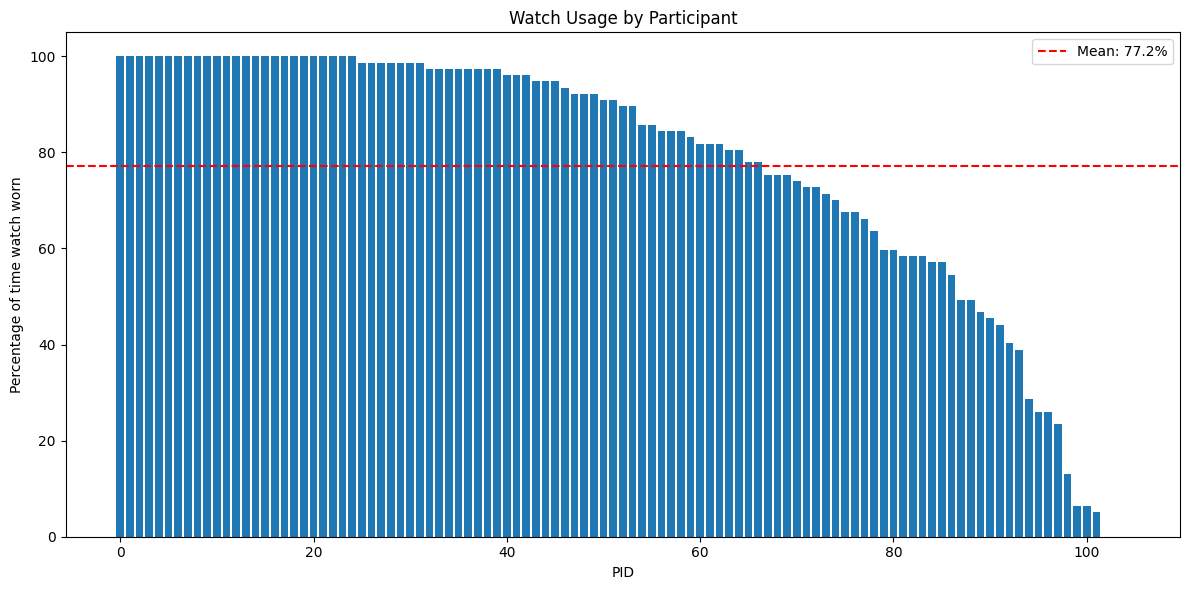

In [200]:
# Calculate percentage of time wore_watch is not 0 for each PID
watch_usage = (df_passive_fe.groupby('PID')['watch_wearing']
               .apply(lambda x: (x != 0).mean() * 100)
               .sort_values(ascending=False))

# Create a bar plot
plt.figure(figsize=(12,6))
plt.bar(range(len(watch_usage)), watch_usage)
plt.xlabel('PID')
plt.ylabel('Percentage of time watch worn')
plt.title('Watch Usage by Participant')
plt.axhline(y=watch_usage.mean(), color='r', linestyle='--', label=f'Mean: {watch_usage.mean():.1f}%')
plt.legend()
plt.tight_layout()

# Print summary statistics
print("\nWatch usage summary statistics:")
print(watch_usage.describe().round(1))



In [196]:
mlm_affect_results_df.head(20).round(2)

,feature,coefficient,coefficient_se,z,abs_z,p_value,n_groups,min_obs,max_obs,mean_obs,median_obs,converged,coef_beta,SE,ci_lower,ci_upper
16,passive_sk_device_total_screen_wakes,0.10,0.01,7.04,7.04,0.0,105,12,77,52.50,51.0,True,0.14,0.02,0.10,0.18
1,passive_hk_activity_appleStandTime,0.12,0.02,6.91,6.91,0.0,99,10,77,57.91,63.0,True,0.17,0.02,0.12,0.22
4,passive_hk_activity_steps,0.12,0.02,6.82,6.82,0.0,104,38,77,68.59,73.5,True,0.16,0.02,0.12,0.21
2,passive_hk_activity_distanceWalkingRunning,0.12,0.02,6.78,6.78,0.0,104,38,77,68.61,73.5,True,0.16,0.02,0.12,0.21
31,passive_sk_visits_unknown_count,0.10,0.02,5.90,5.90,0.0,85,17,75,47.19,48.0,True,0.13,0.02,0.09,0.18
355,fe_rollingMean_3_passive_hk_activity_appleStan...,0.09,0.02,5.47,5.47,0.0,102,10,77,62.06,67.0,True,0.12,0.02,0.08,0.17
364,fe_rollingMean_3_passive_hk_activity_steps,0.09,0.02,5.46,5.46,0.0,104,39,77,68.83,73.5,True,0.12,0.02,0.08,0.17
358,fe_rollingMean_3_passive_hk_activity_distanceW...,0.09,0.02,5.41,5.41,0.0,104,39,77,68.83,73.5,True,0.12,0.02,0.08,0.17
0,passive_hk_activity_activeEnergyBurned,0.08,0.02,5.29,5.29,0.0,99,11,77,60.92,66.0,True,0.11,0.02,0.07,0.15
28,passive_sk_visits_home_elapsed,-0.08,0.02,-4.96,4.96,0.0,85,17,75,47.25,48.0,True,-0.12,0.02,-0.16,-0.07


#### Top Predictors

In [40]:
mlm_wellbeing_results_df.head(20).round(2)

,feature,coefficient,coefficient_sd,t_value,abs_t_value,p_value,n_groups,min_group_size,max_group_size,mean_group_size
2,passive_hk_activity_distanceWalkingRunning,0.13,0.01,14.64,14.64,0.00,104,39,77,68.69
4,passive_hk_activity_steps,0.13,0.01,14.59,14.59,0.00,104,39,77,68.69
1,passive_hk_activity_appleStandTime,0.14,0.01,13.18,13.18,0.00,99,10,77,57.96
0,passive_hk_activity_activeEnergyBurned,0.11,0.01,8.81,8.81,0.00,93,10,75,38.45
16,passive_sk_device_total_screen_wakes,0.09,0.01,8.60,8.60,0.00,105,12,77,53.64
33,passive_sk_visits_unknown_count,0.10,0.01,7.95,7.95,0.00,86,12,75,49.24
29,passive_sk_visits_home_elapsed,-0.08,0.01,-6.81,6.81,0.00,86,12,75,49.24
70,passive_sk_device_total_usage_navigation,0.05,0.01,6.23,6.23,0.00,105,39,77,68.71
31,passive_sk_visits_unknown_elapsed,0.07,0.01,5.60,5.60,0.00,86,12,75,49.24
15,passive_sk_device_total_unlocks,0.06,0.01,5.31,5.31,0.00,105,12,77,53.64


# Save Data


In [1]:
mlm_gap_results_df.to_csv('mlm_gap_results_df.csv', index=False)
mlm_affect_results_df.to_csv('mlm_affect_results_df.csv', index=False)

# Data
df_passive_fe.to_csv('df_passive_fe.csv', index=False)

NameError: name 'mlm_gap_results_df' is not defined

# Visualizations

## Initial Day Fluctuation

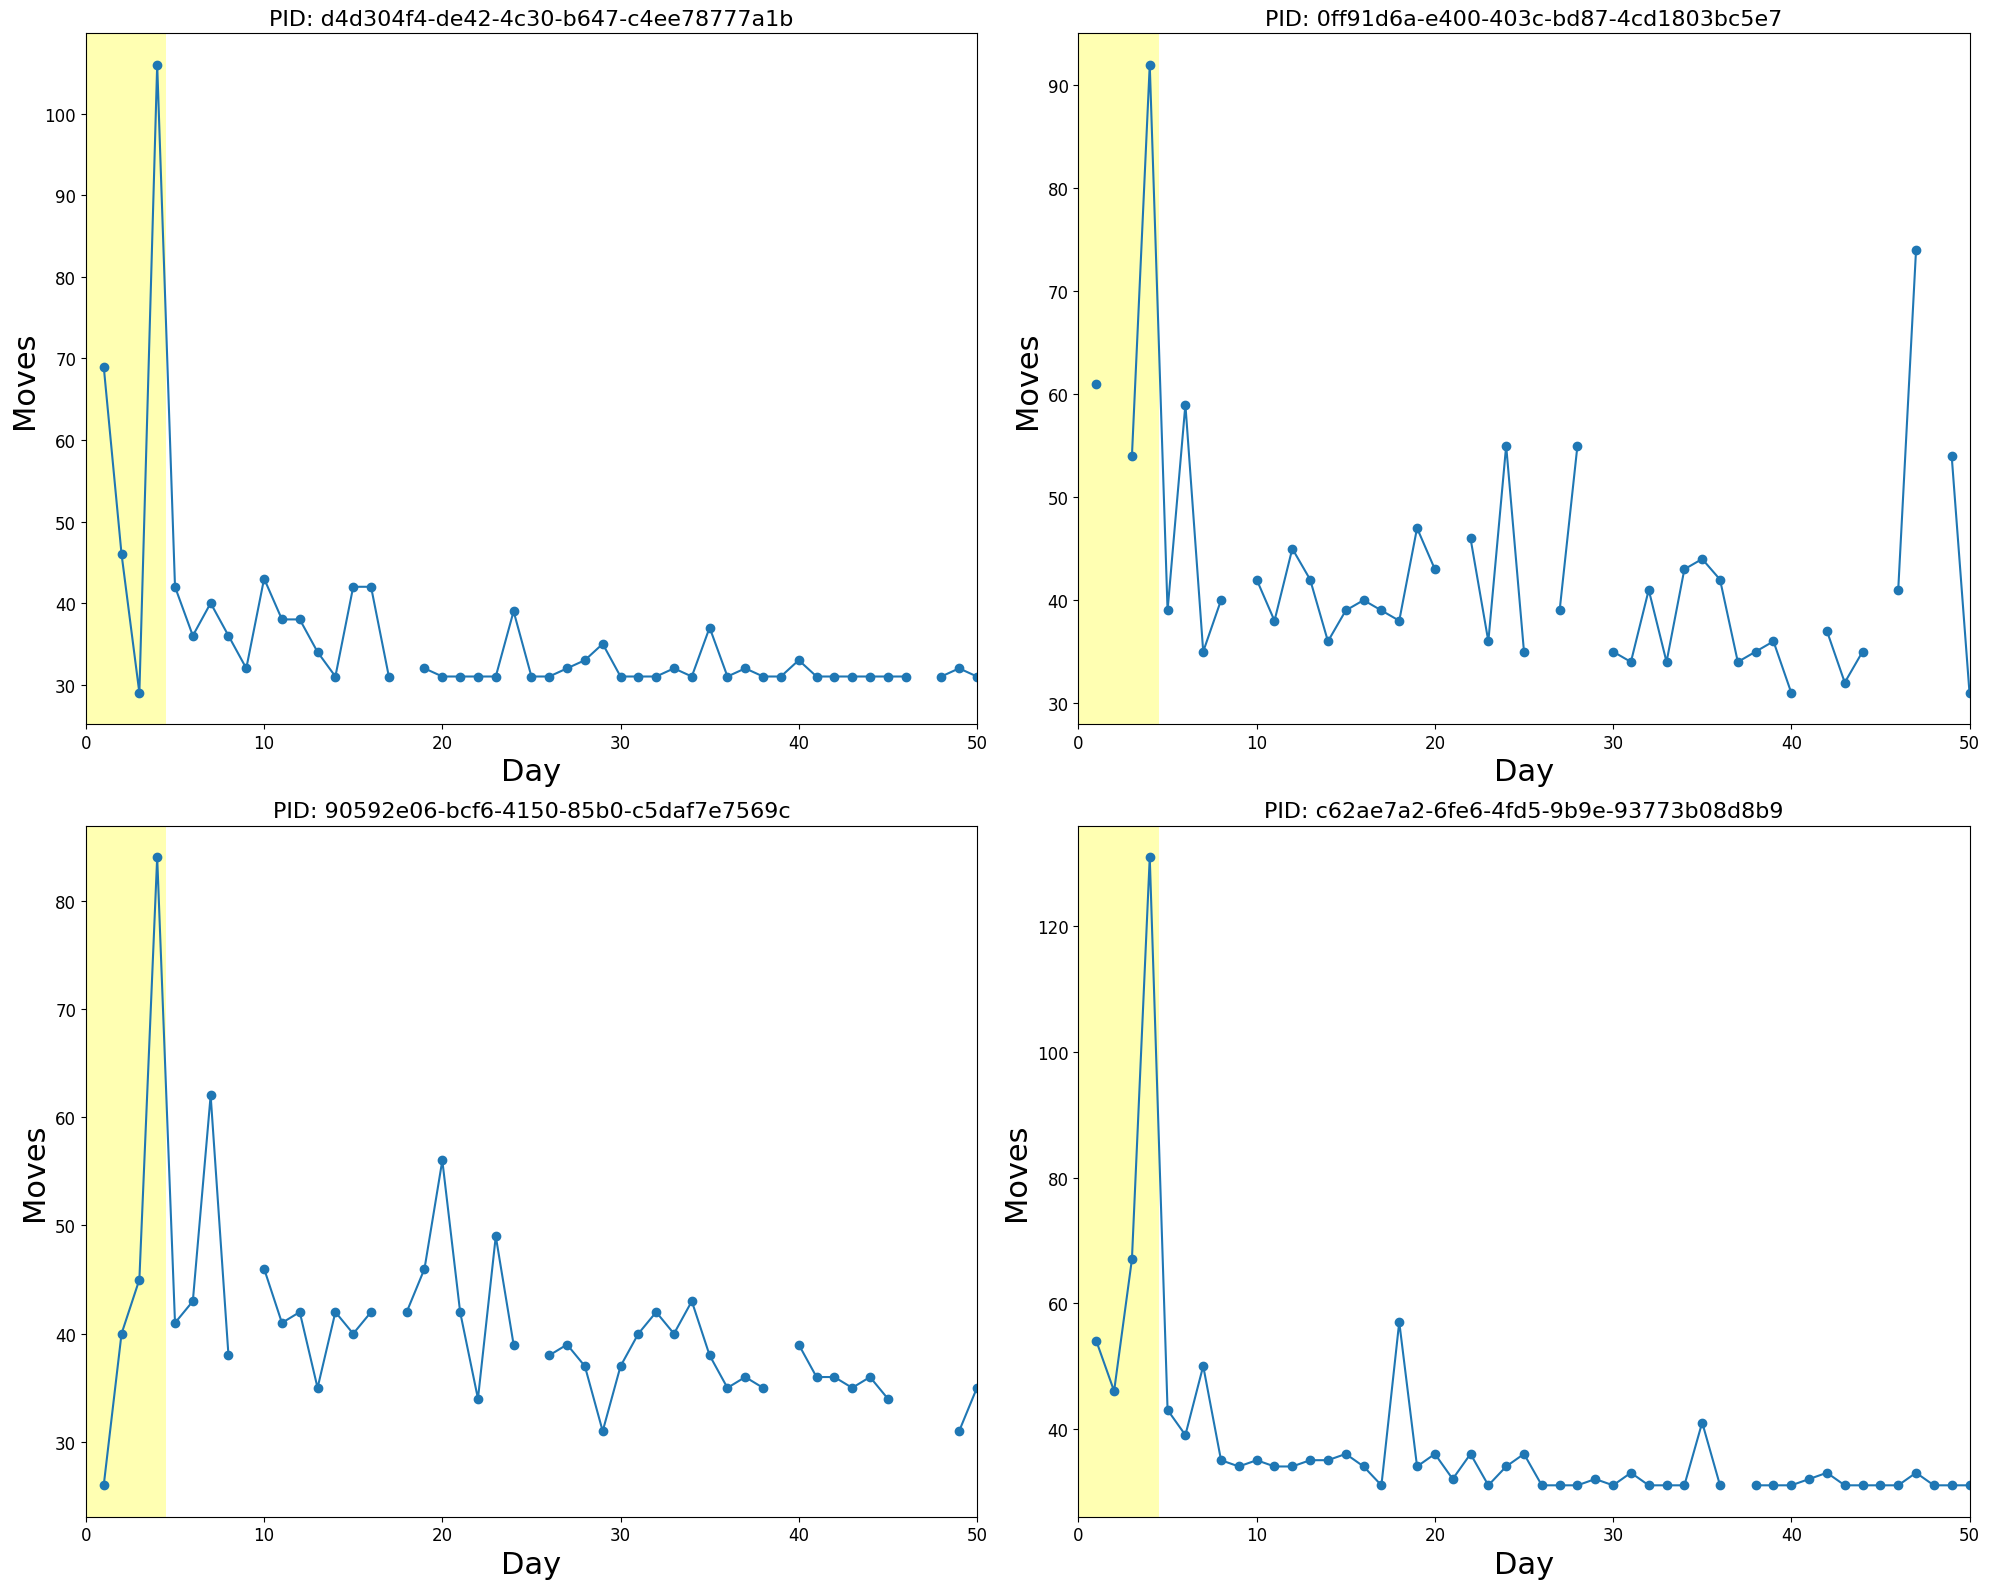

Plotted task_hanoi_moves for PIDs: ['d4d304f4-de42-4c30-b647-c4ee78777a1b', '0ff91d6a-e400-403c-bd87-4cd1803bc5e7', '90592e06-bcf6-4150-85b0-c5daf7e7569c', 'c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9']


In [ ]:
# Specify the PIDs to plot
pids_to_plot = [
    'd4d304f4-de42-4c30-b647-c4ee78777a1b',
    '0ff91d6a-e400-403c-bd87-4cd1803bc5e7',
    '90592e06-bcf6-4150-85b0-c5daf7e7569c',
    'c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9'
]

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

for i, pid in enumerate(pids_to_plot):
    # Filter data for the selected PID and first 50 days
    pid_data = df[(df['PID'] == pid) & (df['day'] <= 50)]
    
    # Plot task_hanoi_moves
    axs[i].plot(pid_data['day'], pid_data['task_hanoi_moves'], marker='o')
    
    # Highlight the first 4.5 days with a background color
    axs[i].axvspan(0, 4.5, facecolor='yellow', alpha=0.3)
    
    axs[i].set_xlabel('Day', fontsize=22)
    axs[i].set_ylabel('Moves', fontsize=22)
    axs[i].set_title(f'PID: {pid}', fontsize=16)
    
    # Set x-axis limits and ticks
    axs[i].set_xlim(0, 50)
    axs[i].set_xticks(range(0, 51, 10))
    
    # Increase tick label size
    axs[i].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

print(f"Plotted task_hanoi_moves for PIDs: {pids_to_plot}")
